**[ Skin Lesion Classification ]**

# ***Connect to google drive***

Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Libraries***

* *Importing required libraries*

***Specific Librairies***

In [2]:
pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install hiclass 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


***General Libraries***

In [4]:
import os
import time
import math
import random
import pickle
import mahotas  
import cv2 as cv
import numpy as np
import pandas as pd
import sklearn as sk
import numpy.ma as ma
import networkx as nx
import xgboost as xgb
import matplotlib

from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow  # Colab
from tabulate import tabulate

from scipy import ndimage
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.color import rgb2lab, lab2rgb
from skimage.measure import label, moments, perimeter
from skimage.morphology import convex_hull_image
from skimage.filters import threshold_multiotsu, threshold_otsu
from skimage.feature import hog, local_binary_pattern, greycomatrix, greycoprops

from sklearn import linear_model, preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score, roc_curve, auc

from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlxtend.classifier
from mlxtend.classifier import StackingCVClassifier
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerNode, LocalClassifierPerLevel

# ***Helper Functions***

* *Definition of all functions used for Machine Learning classification.*

## *General Functions*

In [5]:
def get_prediction_score(y_label, y_predict):
    '''param : y_label --> True classification label
             y_predict --> Predicted classification label
      return : scores  --> List of different evaluation metrics' prediction scores'''

    scores = {}  # empty list to store the computed metrics
    scores['Accuracy'] = accuracy_score(y_label, y_predict)
    scores['Balanced Accuracy'] = balanced_accuracy_score(y_label, y_predict)
    scores['Precision'] = precision_score(y_label, y_predict, average='macro')
    scores['Recall'] = recall_score(y_label, y_predict, average='macro')
    scores['Confusion Matrix'] = confusion_matrix(y_label, y_predict)    
    
    return scores  

In [6]:
def plot_roc(labels, preds, flag, model_name):
    '''param : labels  --> True classification label
                preds  --> Predicted classification label
                flag   --> Boolean variable to determine if the ROC curves would be plotted (flag==True) or not (flag==False)
                clf    --> String containing the model's name
      return : roc_auc --> Dictionary of AUC values for each class'''  

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 3
    class_names = ['Benign', 'Melanoma', 'Seborrheic-Keratosis']
    colors = ['#f06e93', '#327ba8', '#f0c96e']
    for i in range(n_classes):
        actuals = (np.array(labels) == i).astype(np.uint8)  # Creating a one-vs-rest array for each class
        fpr[i], tpr[i], _ = roc_curve(actuals, preds[:, i])  # Computing the FPR and TPR
        roc_auc[i] = auc(fpr[i], tpr[i])  # Computing the AUC values for class i

    if(flag == True):  # If flag is True, then display the ROC curves
      for i in range(n_classes):
          plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))  # roc_auc_score

      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic [ROC] for {0} Classifier'.format(model_name))
      plt.legend(loc="lower right")
      plt.show()
    return roc_auc

In [7]:
def boundingBox_cropping(maskedImage, binaryMask):
  '''param : maskedImage  --> Color image to be cropped
             binaryMask   --> Binary mask used to find the bounding box
    return : croppedImage --> Color image cropped'''

  cnts, _ = cv.findContours(np.uint8(binaryMask), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)  # Computing the contours of the segmented image
  cnt = max(cnts, key=cv.contourArea)  
  x,y,w,h = cv.boundingRect(cnt)  # Bounding box of largest area
  croppedImage = maskedImage[y:y+h, x:x+w]  # Cropping the image w.r.t the bounding box
  
  return croppedImage

In [8]:
def create_mask(originalImage, binaryImage):  
  '''param : originalImage --> Color image to be masked
             binaryImage   --> Binary mask
    return : maskedImage   --> Masked color image'''

  mask = cv.merge([binaryImage,binaryImage,binaryImage])  # Create a 3d version of the binary mask
  mask = np.uint8(mask)
  maskedImage = cv.bitwise_and(np.uint8(originalImage) , mask)  # Apply bitwise and for masking the image w.r.t the mask
  
  return maskedImage

## *Features Extraction functions*

###***Global Features***

In [9]:
def rotateMask(Im, I=None):  
  '''param : Im --> Binary Mask
             I  --> Color image
    return : r  --> Rotated Mask or Color Image '''
  
  ret, MaskI = cv.threshold(Im[:,:,0], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
  MaskI = MaskI.astype(np.uint8)
  # Get the Mask's contour and find the one with the Minimum Area
  contours,_ = cv.findContours(MaskI.copy(), 1, 1) # 
  rect = cv.minAreaRect(contours[0])

  (x,y),(w_,h_), a = rect  # a is the 'angle'
  (h, w) = (max(MaskI.shape[:2]), max(MaskI.shape[:2]))  # The shape of the image will be the maximum when rotating, to avoid cropped regions

  center = ((MaskI.shape[1]) / 2, (MaskI.shape[0])  / 2)  # Compute the center of the Mask
  M = cv.getRotationMatrix2D(center, round(a, 1), 1)  # Rotate the Mask according to the computed angle 'a'
  if I is None :
    r = cv.warpAffine(Im, M, (w, h))  # If only Mask is provided, we return the rotated Mask
  else :
    r = cv.warpAffine(I, M, (w, h))  # If Colored image is provided, we return the rotated Image
  return r

In [10]:
def shapeAsymmetry(Im):
  '''param : Im --> Binary Mask
    return : r  --> Shape Asymmetry measure (Ratio between Intersection and Total Areas) '''
  
  Mask = rotateMask(Im)  # Rotate the Mask according to the major and minor Axes
  cropped_bin = boundingBox_cropping(Mask, Mask[:,:,0])  # Crop the Mask according to the bounding box
  cropped_bin_flipped = (np.flip(cropped_bin, 1))  # Flip the cropped Mask horizontally (axis 1)
  out = cv.bitwise_and(cropped_bin, cropped_bin_flipped)  # Compute the Intersection between the Mask and Flipped Mask
  
  M = moments(out[:,:,0])
  interArea = M[0,0]  # Intersection Area
  M = moments(cropped_bin[:,:,0])
  totalArea = M[0,0]  # Original Mask's Area
  
  return (interArea/totalArea)  

In [11]:
def solidityRatio(Im):
  '''param : Im --> Binary Mask
    return : r  --> Solidity measure (Ratio between Convex-Hull and Total Areas) '''
  
  Mask = rotateMask(Im)  # Rotate the Mask according to major and minor Axes
  # Binary+OTSU thresholding in case the Mask is not in range (0-255)
  ret, Mask = cv.threshold(Mask[:,:,0], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
  Mask = Mask.astype(np.uint8)
  M = moments(Mask)  # Compute the Mask's moments
  lesionArea = M[0,0]  # Mask's Area

  hull = convex_hull_image(Mask)  # Compute the Convex-Hull of the Mask
  hull = np.interp(hull, (hull.min(), hull.max()), (0, 255))  # Map the values to range(0,255)
  M = moments(hull)
  hullArea = M[0,0]  # Convex-Hull Mask's Area

  return (lesionArea/hullArea)

In [12]:
def elongationRatio(Im):
  '''param : Im --> Binary Mask
    return : r  --> Elongation measure (Ratio between the Height and Width) '''

  M = rotateMask(Im)  # Rotate the Mask according to major and minor Axis
  # Binary+OTSU thresholding in case the Mask is not in range (0-255)
  ret, M = cv.threshold(M[:,:,0], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
  M = M.astype(np.uint8)
  # Get the Mask's contour and find the one with the Minimum Area
  contours,_ = cv.findContours(M.copy(), 1, 1)  
  rect = cv.minAreaRect(contours[0])  
  (x,y),(w,h), a = rect  # 'a' is the angle
  return float(h/(w+0.0001))  # Adding a random small number to avoid division by 0

In [13]:
def compactnessIndex(Im):
  '''param : Im --> Binary Mask
    return : CI --> Compactness Index measure '''

  # Binary+OTSU thresholding in case the Mask is not in range (0-255)
  ret, Mask_ = cv.threshold(Im[:,:,0], 0, 1, cv.THRESH_BINARY+cv.THRESH_OTSU)
  Mask_ = Mask_.astype(np.uint8)
  P = perimeter(Mask_, 8)  # Compute the Mask's Perimeter
  M = moments(Mask_)
  A = M[0,0]  # Compute the Mask's Area

  CI = (4*math.pi*A)/(P**2)  # Compactness Index' formula
  return CI

In [14]:
def colorAsymmetry(I, Mask):
  '''param : I      --> Color Image
             Mask   --> Binary Mask
    return : hC, vC --> Color Asymmetry measure by comparing Horizontal and Vertical cuts' histograms '''

  # Binary+OTSU thresholding in case the Mask is not in range (0-255)
  ret, Mask_ = cv.threshold(Mask[:,:,0], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
  cropped_mask = boundingBox_cropping(cv.merge([Mask_,Mask_,Mask_]), Mask_)  # Crop the Mask according to the bounding box
  cropped_mask = cv.resize(cropped_mask, (I.shape[1], I.shape[0]), interpolation = cv.INTER_AREA)  # Resize the Mask in case it's different from the segmented image 'I'
  masked = create_mask(I, cropped_mask[:,:,0])  # Create a Masked version of image 'I'
  r = rotateMask(cropped_mask, masked)  # Rotate the masked Image according to major and minor Axes
  rm = rotateMask(cropped_mask)  # Rotate the Mask according to major and minor Axes
  cropped = boundingBox_cropping(r, rm[:,:,0])   # Crop the masked Image according to the bounding box
  cropped_m = boundingBox_cropping(rm, rm[:,:,0])   # Crop the Mask according to the bounding box
 
  #  ---------------------------------------------------------------------------
  # Horizontal Cuts for the cropped Mask
  mask1=cropped_m[0:int((cropped.shape[0])/2), :]
  mask2=cropped_m[int((cropped.shape[0])/2):cropped.shape[0], :]
  # Vertical Cuts for the cropped Mask
  mask3=cropped_m[:, 0:int((cropped.shape[1])/2)]
  mask4=cropped_m[:, int((cropped.shape[1])/2):cropped.shape[1]]
  #  ---------------------------------------------------------------------------

  # Horizontal Cut : Compute normalized histograms of each Horizontal half and compare them
  H1 = cv.calcHist([cropped[0:int((cropped.shape[0])/2), :]], [0,1,2], mask1[:,:,0], [8, 8, 8], [0, 256, 0, 256, 0, 256])
  cv.normalize(H1, H1, alpha=0, beta=1, norm_type=cv.NORM_MINMAX);
  H2 = cv.calcHist([cropped[int((cropped.shape[0])/2):cropped.shape[0], :]], [0,1,2], mask2[:,:,0], [8, 8, 8], [0, 256, 0, 256, 0, 256])
  cv.normalize(H2, H2, alpha=0, beta=1, norm_type=cv.NORM_MINMAX);
  hC = cv.compareHist(H1, H2, method=cv.HISTCMP_CHISQR)

  # Vertical Cut > Compute normalized histograms of each Vertical half and compare them
  H1 = cv.calcHist([cropped[:, 0:int((cropped.shape[1])/2)]], [0,1,2], mask3[:,:,0], [8, 8, 8], [0, 256, 0, 256, 0, 256])
  cv.normalize(H1, H1, alpha=0, beta=1, norm_type=cv.NORM_MINMAX);
  H2 = cv.calcHist([cropped[:, int((cropped.shape[1])/2):cropped.shape[1]]], [0,1,2], mask4[:,:,0], [8, 8, 8], [0, 256, 0, 256, 0, 256])
  cv.normalize(H2, H2, alpha=0, beta=1, norm_type=cv.NORM_MINMAX);
  vC = cv.compareHist(H1, H2, method=cv.HISTCMP_CHISQR)

  return hC, vC

In [15]:
def variegation(Im):
  '''param : Im            --> Binary Mask
    return : C_r, C_g, C_b --> Color Variegation measures for each RGB Channel '''  

  # Split Color channels  
  lesion_r = Im[:, :, 2]
  lesion_g = Im[:, :, 1]
  lesion_b = Im[:, :, 0]

  # Compute the normalized Standard Deviation of each channel
  C_r = np.std(lesion_r) / np.max(lesion_r)
  C_g = np.std(lesion_g) / np.max(lesion_g)
  C_b = np.std(lesion_b) / np.max(lesion_b)
  return C_r, C_g, C_b

### ***Feature Extraction***

* *Shape features*

In [16]:
def extract_shape_fd(Img):
    """Extract Shape Features
    --> param Img : ndarray, BGR image
    --> return shape_feature : ndarray, contains Shape descriptors of the image
    """
    blue_Img = Img[:,:,0]  # Use the blue channel of the Image

    # Histogram of Oriented Gradients (HOG) : 
    image = cv.resize(blue_Img, (128,64), interpolation = cv.INTER_AREA)
    hog_fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    
    # Hu Moments : 
    hu_fd = cv.HuMoments(cv.moments(blue_Img)).flatten()  # 7 Moments
       
    return hog_fd, hu_fd  

* *Texture features*

In [17]:
def extract_texture_fd(Img):
    """Extract Texture Features
    --> param Img : ndarray, BGR image
    --> return texture_features : ndarrays, contains Texture descriptors of the image
    """
    blue_Img = Img[:,:,0]  # Use the blue channel of the Image

    # Local Binary Pattern (LBP) : 
    lbp = local_binary_pattern(blue_Img, P=24, R=8, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_fd, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Haralick : 
    haralick_fd = mahotas.features.haralick(blue_Img).mean(axis=0)  # 14 Statistics

    # Gray Level Co-occurance Matrix (GLCM) : 
    distance = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
    glcm_fd = []
    glcm_mat = greycomatrix(blue_Img, distances=distance, angles=angles, symmetric=True, normed=True)
    block_glcm = np.hstack([greycoprops(glcm_mat, props).ravel() for props in properties])
    glcm_fd.append(block_glcm)
    glcm_fd = np.concatenate(glcm_fd)

    return lbp_fd, haralick_fd, glcm_fd

* *Color features*

In [18]:
def color_moments(Img):
    """ Extract Color Moments of an image.
    --> param Img : ndarray, BGR image
    --> return color_moments : ndarray, contains the 4 Central Color Moments """

    c1, c2, c3 = cv.split(Img)
    color_feature = []  # Initialize the color feature

    # -- The first central moment - average
    c1_mean = np.mean(c1)  # np.sum(h)/float(N)
    c2_mean = np.mean(c2)  # np.sum(s)/float(N)
    c3_mean = np.mean(c3)  # np.sum(v)/float(N)
    color_feature.extend([c1_mean, c2_mean, c3_mean])
    # -- The second central moment - standard deviation
    c1_std = np.std(c1)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    c2_std = np.std(c2)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    c3_std = np.std(c3)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    color_feature.extend([c1_std, c2_std, c3_std])
    # -- The third central moment - the third root of the skewness
    c1_skewness = np.mean(abs(c1 - c1.mean())**3)
    c2_skewness = np.mean(abs(c2 - c2.mean())**3)
    c3_skewness = np.mean(abs(c3 - c3.mean())**3)
    c1_thirdMoment = c1_skewness**(1./3)
    c2_thirdMoment = c2_skewness**(1./3)
    c3_thirdMoment = c3_skewness**(1./3)
    color_feature.extend([c1_thirdMoment, c2_thirdMoment, c3_thirdMoment])
    # -- The fourth central moment - the variance
    c1_var = c1_std**2  # (np.mean(abs(h - h.mean())**2))
    c2_var = c2_std**2  # (np.mean(abs(s - s.mean())**2))
    c3_var = c3_std**2  # (np.mean(abs(v - v.mean())**2))
    color_feature.extend([c1_var, c2_var, c3_var])

    return color_feature

# ------------------------------------------------------------------------------
def extract_color_histogram(Img, n_bins=8):
    """Extract Color histogram of an image.
    --> param Img : ndarray, BGR image
    --> return feature : ndarray, contains n_bins*n_bins*n_bins of BGR, HSV & L.a.b histogram features of the image
    """
    # --- BGR : ---
    bgr_ft = []
    channels = cv.split(Img)
    colors = ("b", "g", "r")
    for (channel, color) in zip(channels, colors):  
      hist = cv.calcHist([channel], [0], None, [255], [1, 256])     # For each image channel, the normalized histogram is computed
      cv.normalize(hist, hist)
      bgr_ft.extend(hist)  
    bgr_ft = np.array(bgr_ft).reshape(1, -1)

    # --- HSV : ---
    hsv_ft = []
    hsv = cv.cvtColor(Img, cv.COLOR_BGR2HSV) # Convert the image to HSV color-space
    channels = cv.split(hsv)
    colors = ("h", "s", "v")
    for (channel, color) in zip(channels, colors):
      hist = cv.calcHist([channel], [0], None, [255], [1, 256])  # For each image channel, the normalized histogram is computed
      cv.normalize(hist, hist)
      hsv_ft.extend(hist)  
    hsv_ft = np.array(hsv_ft).reshape(1, -1)

    # --- LAB : ---
    lab_ft = []
    hsv = cv.cvtColor(Img, cv.COLOR_BGR2HSV) # Convert the image to Lab color-space
    channels = cv.split(hsv)
    colors = ("l", "a", "b")
    for (channel, color) in zip(channels, colors):
      hist = cv.calcHist([channel], [0], None, [255], [1, 256])  # For each image channel, the normalized histogram is computed
      cv.normalize(hist, hist)
      lab_ft.extend(hist)  
    lab_ft = np.array(lab_ft).reshape(1, -1)

    return bgr_ft, hsv_ft, lab_ft

In [19]:
def extract_color_fd(Img):
    """ Extract Color features 
    --> param Img : ndarray, BGR image
    --> return color_feature: ndarray, contains color features of the image """

    bgr_ft, hsv_ft, lab_ft = extract_color_histogram(Img)  # Extract Color Histograms
    rgb_color_fd = color_moments(Img)  # RGB Color Moments
    hsv_color_fd = color_moments(cv.cvtColor(Img, cv.COLOR_BGR2HSV))  # HSV Color Moments
    
    return bgr_ft, hsv_ft, lab_ft, rgb_color_fd, hsv_color_fd

* *Global features*

In [20]:
def extract_global_fd(Img, Mask):
    """Extract Global Shape & Color Features
    --> param Img : ndarray, BGR image
              Mask : ndarray, Binary Mask
    --> return shape_feature : ndarray, contains Global Shape & Color descriptors of the image
    """
    # Shape Asymmetry :
    shapeAsym_fd = shapeAsymmetry(Mask)

    # shape Compactness Index :
    compactness_fd = compactnessIndex(Mask)
    
    # Shape Elongation Ratio :
    elongation_fd = elongationRatio(Mask)

    # Shape solidity Ratio : 
    solidity_fd = solidityRatio(Mask)

    # Color Asymmetry : 
    colorAsymH_fd, colorAsymV_fd = colorAsymmetry(Img, Mask)

    # Color Variegation :
    variegation_fd = variegation(Img)

    return shapeAsym_fd, compactness_fd, elongation_fd, solidity_fd, colorAsymH_fd, colorAsymV_fd, variegation_fd

* *All features*

In [21]:
def extract_features(Img, Mask):
    """ Extract all features (shape, texture and color features) of an image.
    --> param Img : ndarray, BGR image
        Mask : ndarray, Binary Mask
    --> return global_feature : ndarray, contains shape, texture and color features of the image """
    
    # Extract all of Shape, Texture, Color and Global Features :
    hog_fd, hu_fd  = extract_shape_fd(Img)
    lbp_fd, haralick_fd, glcm_fd = extract_texture_fd(Img)
    bgr_ft, hsv_ft, lab_ft, rgb_color_fd, hsv_color_fd  = extract_color_fd(Img)
    shapeAsym_fd, compactness_fd, elongation_fd, solidity_fd, colorAsymH_fd, colorAsymV_fd, variegation_fd = extract_global_fd(Img, Mask)
    
    return hog_fd, hu_fd, lbp_fd, haralick_fd, glcm_fd, bgr_ft, hsv_ft, lab_ft, rgb_color_fd, hsv_color_fd, shapeAsym_fd, compactness_fd, elongation_fd, solidity_fd, colorAsymH_fd, colorAsymV_fd, variegation_fd


In [22]:
def prepare_dataset(input_path, mask_path, train, batch_size, n, img_size=None):
    """Process images of different classes and extract labels and global features of images
    --> Params input_path : Images' path directory
        mask_path : Mask Images' path directory
        train : Labels of the data
        batch_size : Number of images to process 
        n : Starting image's index 
        image_size : Image size in case it needs to be padded
    --> return : Features and Label arrays
    """
 
    # Initialize empty arrays to store the features 
    hog_fd = []
    hu_fd = []
    lbp_fd = []
    haralick_fd = [] 
    glcm_fd = []
    bgr_fd = []
    hsv_fd = []
    lab_fd = []
    rgb_color_fd = [] 
    hsv_color_fd = []
    shapeAsym_fd = []
    compactness_fd = []
    elongation_fd = []
    solidity_fd = []
    colorAsymH_fd = []
    colorAsymV_fd = []
    variegation_fd = []
    labels = []
    folder_list = os.listdir(input_path)
    folder_list = sorted(folder_list)
    for filename in folder_list[n:n+batch_size]:
        print("Image : ", filename)
        img = cv.imread(os.path.join(input_path, filename))[:, :, :3]  # Read images

        mask = cv.imread(os.path.join(mask_path, filename))[:, :, :3]  # Read Mask images
        # Compute features and store them in their respective arrays 
        hog_ft, hu_ft, lbp_ft, haralick_ft, glcm_ft, bgr_ft, hsv_ft, lab_ft, rgb_color_ft, hsv_color_ft, shapeAsym_ft, compactness_ft, elongation_ft, solidity_ft, colorAsymH_ft, colorAsymV_ft, variegation_ft = extract_features(img, mask)
        hog_fd.append(hog_ft)
        hu_fd.append(hu_ft)
        lbp_fd.append(lbp_ft)
        bgr_fd.append(bgr_ft)
        hsv_fd.append(hsv_ft)
        lab_fd.append(lab_ft)
        haralick_fd.append(haralick_ft)
        glcm_fd.append(glcm_ft)
        rgb_color_fd.append(rgb_color_ft)
        hsv_color_fd.append(hsv_color_ft)
        shapeAsym_fd.append(shapeAsym_ft)
        compactness_fd.append(compactness_ft)
        elongation_fd.append(elongation_ft)
        solidity_fd.append(solidity_ft)
        colorAsymH_fd.append(colorAsymH_ft)
        colorAsymV_fd.append(colorAsymV_ft)
        variegation_fd.append(variegation_ft)
          
    labels = train['label']  # Extract Labels from 'train['label']
    labels = labels[n:n+batch_size]

    return np.array(hog_fd), np.array(hu_fd), np.array(lbp_fd), np.array(haralick_fd), np.array(glcm_fd), np.array(bgr_fd), np.array(hsv_fd), np.array(lab_fd), np.array(rgb_color_fd), np.array(hsv_color_fd), np.array(shapeAsym_fd), np.array(compactness_fd), np.array(elongation_fd), np.array(solidity_fd), np.array(colorAsymH_fd), np.array(colorAsymV_fd), np.array(variegation_fd), np.array(labels)

# ***Dataset Definition and Split***

* *This bloc of code reads the images' IDs from CSV files, and store them with the corresponding suffix ('.jpg' for images, and '_mask.png' for masks), for all of the Train, Test and Validation sets.*


In [23]:
train = pd.read_csv('/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/train_2000_.csv')
val = pd.read_csv('/content/drive/MyDrive/Skin Lesions Dataset/Dataset/Dataset_Kaouther/Dataset/validation_150.csv')
test = pd.read_csv('/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/test_600_.csv')

# reading the training images' Id
Im_train = []
Gt_train = []
for i in (range(train.shape[0])):
  Im_train.append(train['image_id'][i] + '.jpg')
  Gt_train.append(train['image_id'][i] + '_mask.png')

# reading the validation images' Id
Im_val = []
Gt_val = []
for i in (range(val.shape[0])):
  Im_val.append(val['image_id'][i] + '.jpg')
  Gt_val.append(val['image_id'][i] + '_mask.png')

# reading the testing images' Id
Im_test = []
Gt_test = []
for i in (range(test.shape[0])):
  Im_test.append(test['image_id'][i] + '.jpg')
  Gt_test.append(test['image_id'][i] + '_mask.png')

## *Images from Deep Learning Masks*

* *In these blocs of code, segmentation masks obtained from Deep Learning are rescaled (to a max size of 500px) and saved in a Drive Folder in the first part.*

* *In the second part, previously resized and hair removed images are cropped in such way to fit the boundingbox of the Deep Learning masks.*

***Saving Rescaled Deep Learning Masks from Train, Validation & Test sets***


In [ ]:
# # # -----  [ Saved Rescaled DL Masks from Train Set ]  -----  :

# start_time = time.time()
# maxSize = 500  # Desired Maximum size of width/height 

# for i in range(len(Gt_train)):
#   for n, nii in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset/Dataset_Kaouther/Dataset/segmentation_results/train/{Gt_train[i]}']):
#       try:
#         image = Image.open(nii)
#         image = np.array(image)
#         image = image.astype(np.uint8)
#       except FileNotFoundError:
#         print(f'Image {Gt_train[i]} does not exist')
#         continue
      
#       scale_percent = round((maxSize / max(image.shape[0], image.shape[1])),2)  # Percent to scale images to get ~maxSize as the maximum value for width or height while keeping proportions
#       width = int(image.shape[1] * scale_percent)
#       height = int(image.shape[0] * scale_percent)
#       dim = (width, height)
#       shape1 = image.shape
      
#       # Resize image
#       image = cv.resize(image, dim, interpolation = cv.INTER_AREA)
#       print("Image #", i, "- Original Image Shape = ", shape1, "- Resized Image Shape = ", image.shape)

#       # Save Inpainted Images in 'Inpainted_Images_Train' Folder
#       ## cv.imwrite(f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Train/{Im_train[i]}', image)

# end_time = time.time()
# total_time2 = end_time-start_time
# print("Time of execution = %s seconds " % (total_time2))


# ------------------------------------------------------------------------------
# # # -----  [ Saved Rescaled DL Masks from Validation Set ]  -----  :

# start_time = time.time()
# maxSize = 500  # Desired Maximum size of width/height 

# for i in range(len(Gt_val)):
#   for n, nii in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset/Dataset_Kaouther/Dataset/segmentation_results/val/{Gt_val[i]}']):
#       try:
#         image = Image.open(nii)
#         image = np.array(image)
#         image = image.astype(np.uint8)
#       except FileNotFoundError:
#         print(f'Image {Gt_val[i]} does not exist')
#         continue
      
#       scale_percent = round((maxSize / max(image.shape[0], image.shape[1])),2)  # Percent to scale images to get ~maxSize as the maximum value for width or height while keeping proportions
#       width = int(image.shape[1] * scale_percent)
#       height = int(image.shape[0] * scale_percent)
#       dim = (width, height)
#       shape1 = image.shape
      
#       # Resize image
#       image = cv.resize(image, dim, interpolation = cv.INTER_AREA)
#       print("Image #", i, "- Original Image Shape = ", shape1, "- Resized Image Shape = ", image.shape)

#       # Save Inpainted Images in 'Inpainted_Images_Train' Folder
#       ## cv.imwrite(f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Validation/{Im_val[i]}', image)

# end_time = time.time()
# total_time2 = end_time-start_time
# print("Time of execution = %s seconds " % (total_time2))


# ------------------------------------------------------------------------------
# # # -----  [ Saved Rescaled DL Masks from Test Set ]  -----  :

# import time
# start_time = time.time()
# maxSize = 500  # Desired Maximum size of width/height 

# for i in range(len(Gt_test)):
#   for n, nii in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset/Dataset_Kaouther/Dataset/segmentation_results/test/{Gt_test[i]}']):
#       try:
#         image = Image.open(nii)
#         image = np.array(image)
#         image = image.astype(np.uint8)
#       except FileNotFoundError:
#         print(f'Image {Gt_test[i]} does not exist')
#         continue
      
#       scale_percent = round((maxSize / max(image.shape[0], image.shape[1])),2)  # Percent to scale images to get ~maxSize as the maximum value for width or height while keeping proportions
#       width = int(image.shape[1] * scale_percent)
#       height = int(image.shape[0] * scale_percent)
#       dim = (width, height)
#       shape1 = image.shape
      
#       # Resize image
#       image = cv.resize(image, dim, interpolation = cv.INTER_AREA)
#       print("Image #", i, "- Original Image Shape = ", shape1, "- Resized Image Shape = ", image.shape)

#       # Save Inpainted Images in 'Inpainted_Images_Train' Folder
#       ## cv.imwrite(f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Test/{Im_test[i]}', image)

# end_time = time.time()
# total_time2 = end_time-start_time
# print("Time of execution = %s seconds " % (total_time2))

***Saving Cropped Inpainted & Resized Images from Deep Learning Masks***

In [ ]:
# # # -----  [ Saved Cropped Inpaint-Rescaled Train Images from DL Masks ]  -----  :

# start_time = time.time()

# for i in range(len(Im_train)):  
#   for n, nii in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Inpainted_Resized500/Train/inpainted_images/{Im_train[i]}']):
#       try:
#         image = cv.imread(nii)
#       except FileNotFoundError:
#         print(f'Image {Im_train[i]} does not exist')
#         continue

#   for n, nii2 in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Train/{Im_train[i]}']):
#       try:
#         gt = cv.imread(nii2, 0)
#         gt = gt.astype(np.uint8)
#       except FileNotFoundError:
#         print(f'Image {Im_train[i]} does not exist')
#         continue
      
#       if(gt.all() == np.zeros(gt.shape).all()):  # In case the mask is empty 
#         Cropped = image
#       else :
#         Cropped = boundingBox_cropping(image, gt)
#       # Save Segmented Images's Mask in 'SegmentedTrain_ASF_OTSU_masked/Images/' Folder
#       ##cv.imwrite(f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL_Cropped/Images/Train/{Im_train[i]}', Cropped)

#   print('Image ', i, 'is done !')

# end_time = time.time()
# total_time2 = end_time-start_time
# print("Time of execution = %s seconds " % (total_time2))


# ------------------------------------------------------------------------------
# # # # -----  [ Saved Cropped Inpaint-Rescaled Validation Images from DL Masks ]  -----  :

# start_time = time.time()

# for i in range(len(Im_val)):
#   for n, nii in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Inpainted_Resized500/Validation/{Im_val[i]}']):
#       try:
#         image = cv.imread(nii)
#       except FileNotFoundError:
#         print(f'Image {Im_val[i]} does not exist')
#         continue

#   for n, nii2 in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Validation/{Im_val[i]}']):
#       try:
#         gt = cv.imread(nii2, 0)
#         gt = gt.astype(np.uint8)
#       except FileNotFoundError:
#         print(f'Image {Im_val[i]} does not exist')
#         continue
      
#       if(gt.all() == np.zeros(gt.shape).all()):  # In case the mask is empty 
#         Cropped = image
#       else :
#         Cropped = boundingBox_cropping(image, gt)
#       # Save Cropped Inpainted Images in 'DL_Cropped/Images/Validation/' Folder
#       ##cv.imwrite(f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL_Cropped/Images/Validation/{Im_val[i]}', Cropped)
  
#   print('Image ', i, 'is done !')

# end_time = time.time()
# total_time2 = end_time-start_time
# print("Time of execution = %s seconds " % (total_time2))


# ------------------------------------------------------------------------------
# # # -----  [ Saved Cropped Inpaint-Rescaled Test Images from DL Masks ]  -----  :

# start_time = time.time()

# for i in range(len(Im_test)):  
#   for n, nii in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Inpainted_Resized500/Test/{Im_test[i]}']):
#       try:
#         image = cv.imread(nii)
#       except FileNotFoundError:
#         print(f'Image {Im_test[i]} does not exist')
#         continue

#   for n, nii2 in enumerate([f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Test/{Im_test[i]}']):
#       try:
#         gt = cv.imread(nii2, 0)
#         gt = gt.astype(np.uint8)
#       except FileNotFoundError:
#         print(f'Image {Im_test[i]} does not exist')
#         continue
#       if(gt.all() == np.zeros(gt.shape).all()):  # In case the mask is empty 
#         Cropped = image
#       else :
#         Cropped = boundingBox_cropping(image, gt)

#       # Save Segmented Images's Mask in 'SegmentedTrain_ASF_OTSU_masked/Images/' Folder
#       ##cv.imwrite(f'/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL_Cropped/Images/Test/{Im_test[i]}', Cropped)

#   print('Image ', i, 'is done !')

# end_time = time.time()
# total_time2 = end_time-start_time
# print("Time of execution = %s seconds " % (total_time2))

# ***Feature Extraction and Selection***

## *Features Extraction & Saving*

* *This bloc of code extracts features for each of the training samples.*

* *Note: the number of Train images is 1999 due to the fact that one DL mask was empty and got removed. The same situation for the Test images that are 599 instead of 600.*


In [ ]:
# ------------  Feature Extraction for Training Data  ------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

batch_size_train = 1999  # Number of Train images 
n = 0  # Number from which we start taking data
    
# -- Extract features and labels for Training set :
train_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL_Cropped/Images/Train'
trainMask_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Train'

start = time.time()

print("Feature Extraction from Training Dataset is in progress..\n")
train_hog_ft, train_hu_ft, train_lbp_ft, train_haralick_ft, train_glcm_ft, train_bgr_ft, train_hsv_ft, train_lab_ft, train_rgb_color_ft, train_hsv_color_ft, train_shapeAsym_ft, train_compactness_ft, train_elongation_ft, train_solidity_ft, train_colorAsymH_ft, train_colorAsymV_ft, train_variegation_ft, y_train_ = prepare_dataset(train_path, trainMask_path, train, batch_size_train, n, img_size=None)

end = time.time()
print('Total Time =', (end-start))

Feature Extraction from Training Dataset is in progress..

Image :  ISIC_0000000.jpg
Image :  ISIC_0000001.jpg
Image :  ISIC_0000002.jpg
Image :  ISIC_0000003.jpg
Image :  ISIC_0000004.jpg
Image :  ISIC_0000006.jpg
Image :  ISIC_0000007.jpg
Image :  ISIC_0000008.jpg
Image :  ISIC_0000009.jpg
Image :  ISIC_0000010.jpg
Image :  ISIC_0000011.jpg
Image :  ISIC_0000012.jpg
Image :  ISIC_0000013.jpg
Image :  ISIC_0000014.jpg
Image :  ISIC_0000015.jpg
Image :  ISIC_0000016.jpg
Image :  ISIC_0000017.jpg
Image :  ISIC_0000018.jpg
Image :  ISIC_0000019.jpg
Image :  ISIC_0000020.jpg
Image :  ISIC_0000021.jpg
Image :  ISIC_0000022.jpg
Image :  ISIC_0000023.jpg
Image :  ISIC_0000024.jpg
Image :  ISIC_0000025.jpg
Image :  ISIC_0000026.jpg
Image :  ISIC_0000027.jpg
Image :  ISIC_0000028.jpg
Image :  ISIC_0000029.jpg
Image :  ISIC_0000030.jpg
Image :  ISIC_0000031.jpg
Image :  ISIC_0000032.jpg
Image :  ISIC_0000034.jpg
Image :  ISIC_0000035.jpg
Image :  ISIC_0000036.jpg
Image :  ISIC_0000037.jpg
Image

In [ ]:
# ------------  Feature Extraction for Validation & Test Data  ------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

batch_size_val = 150  # Number of Validation images
batch_size_test = 599  # Number of Test images
n = 0  # Number from which we start taking data
   
# -- Extract features and labels for Validation and Test sets :
val_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL_Cropped/Images/Validation'
valMask_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Validation'
test_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL_Cropped/Images/Test'
testMask_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/DL/Masks/Test'

start = time.time()

print("Feature Extraction from Validation Dataset is in progress..\n")
val_hog_ft, val_hu_ft, val_lbp_ft, val_haralick_ft, val_glcm_ft, val_bgr_ft, val_hsv_ft, val_lab_ft, val_rgb_color_ft, val_hsv_color_ft, val_shapeAsym_ft, val_compactness_ft, val_elongation_ft, val_solidity_ft, val_colorAsymH_ft, val_colorAsymV_ft, val_variegation_ft, y_val_ = prepare_dataset(val_path, valMask_path, val, batch_size_val, n, img_size=None)
print("Feature Extraction from Test Dataset is in progress..\n")
test_hog_ft, test_hu_ft, test_lbp_ft, test_haralick_ft, test_glcm_ft, test_bgr_ft, test_hsv_ft, test_lab_ft, test_rgb_color_ft, test_hsv_color_ft, test_shapeAsym_ft, test_compactness_ft, test_elongation_ft, test_solidity_ft, test_colorAsymH_ft, test_colorAsymV_ft, test_variegation_ft, y_test_ = prepare_dataset(test_path, testMask_path, test, batch_size_test, 0, img_size=None)

end = time.time()
print('Total Time =', (end-start))

Feature Extraction from Validation Dataset is in progress..

Image :  ISIC_0001769.jpg
Image :  ISIC_0001852.jpg
Image :  ISIC_0001871.jpg
Image :  ISIC_0003462.jpg
Image :  ISIC_0003539.jpg
Image :  ISIC_0003582.jpg
Image :  ISIC_0003657.jpg
Image :  ISIC_0003805.jpg
Image :  ISIC_0004337.jpg
Image :  ISIC_0006651.jpg
Image :  ISIC_0006671.jpg
Image :  ISIC_0006815.jpg
Image :  ISIC_0006914.jpg
Image :  ISIC_0007141.jpg
Image :  ISIC_0007156.jpg
Image :  ISIC_0007235.jpg
Image :  ISIC_0007241.jpg
Image :  ISIC_0007332.jpg
Image :  ISIC_0007344.jpg
Image :  ISIC_0007528.jpg
Image :  ISIC_0007796.jpg
Image :  ISIC_0008025.jpg
Image :  ISIC_0008524.jpg
Image :  ISIC_0009995.jpg
Image :  ISIC_0010459.jpg
Image :  ISIC_0012099.jpg
Image :  ISIC_0012109.jpg
Image :  ISIC_0012126.jpg
Image :  ISIC_0012127.jpg
Image :  ISIC_0012143.jpg
Image :  ISIC_0012151.jpg
Image :  ISIC_0012159.jpg
Image :  ISIC_0012160.jpg
Image :  ISIC_0012191.jpg
Image :  ISIC_0012201.jpg
Image :  ISIC_0012204.jpg
Ima

*Concatenating Training and Validation Features*

In [ ]:
# ---  Stacking Training and Validation Features :  ---
trainVal_hog_ft = np.vstack([train_hog_ft, val_hog_ft])
trainVal_hu_ft = np.vstack([train_hu_ft, val_hu_ft])
trainVal_lbp_ft = np.vstack([train_lbp_ft, val_lbp_ft])
trainVal_haralick_ft = np.vstack([train_haralick_ft, val_haralick_ft])
trainVal_glcm_ft = np.vstack([train_glcm_ft, val_glcm_ft])
trainVal_bgr_ft = np.vstack([train_bgr_ft, val_bgr_ft])
trainVal_hsv_ft = np.vstack([train_hsv_ft, val_hsv_ft])
trainVal_lab_ft = np.vstack([train_lab_ft, val_lab_ft])
trainVal_rgb_color_ft = np.vstack([train_rgb_color_ft, val_rgb_color_ft])
trainVal_hsv_color_ft = np.vstack([train_hsv_color_ft, val_hsv_color_ft])
trainVal_shapeAsym_ft = np.hstack([train_shapeAsym_ft, val_shapeAsym_ft])
trainVal_compactness_ft = np.hstack([train_compactness_ft, val_compactness_ft])
trainVal_elongation_ft = np.hstack([train_elongation_ft, val_elongation_ft])
trainVal_solidity_ft = np.hstack([train_solidity_ft, val_solidity_ft])
trainVal_colorAsymH_ft = np.hstack([train_colorAsymH_ft, val_colorAsymH_ft])
trainVal_colorAsymV_ft = np.hstack([train_colorAsymV_ft, val_colorAsymV_ft])
trainVal_variegation_ft = np.vstack([train_variegation_ft, val_variegation_ft])
y_trainVal_ft = np.hstack([y_train_, y_val_])

print('Stacking Features - done !')

*Saving the obtained features in Drive*

In [ ]:
# ----  Save the extracted features in our Save_Folder :  ----
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# --  Save Train Features :
if save_path is not None:      
  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_hog_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_hog_ft, f)
  # print("train_hog_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_hu_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_hu_ft, f)
  # print("train_hu_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_lbp_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_lbp_ft, f)
  # print("train_lbp_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_haralick_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_haralick_ft, f)
  # print("train_haralick_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_glcm_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_glcm_ft, f)
  # print("train_glcm_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_bgr_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_bgr_ft, f)
  # print("train_bgr_ft2 were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_hsv_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_hsv_ft, f)
  # print("train_hsv_ft2 were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_lab_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_lab_ft, f)
  # print("train_lab_ft2 were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_rgb_color_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_rgb_color_ft, f)
  # print("train_rgb_color_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_hsv_color_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_hsv_color_ft, f)
  # print("train_hsv_color_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_shapeAsym_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_shapeAsym_ft, f)
  # print("train_shapeAsym_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_compactness_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_compactness_ft, f)
  # print("train_compactness_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_elongation_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_elongation_ft, f)
  # print("train_elongation_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_solidity_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_solidity_ft, f)
  # print("train_solidity_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_colorAsymH_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_colorAsymH_ft, f)
  # print("train_colorAsymH_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_colorAsymV_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_colorAsymV_ft, f)
  # print("train_colorAsymV_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'train_variegation_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(train_variegation_ft, f)
  # print("train_variegation_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'y_train_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(y_train_, f)
  # print("y_train_ were saved..\n")

# --  Save Train+Validation Features :
if save_path is not None:
  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_hog_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_hog_ft, f)
  # print("trainVal_hog_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_hu_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_hu_ft, f)
  # print("trainVal_hu_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_lbp_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_lbp_ft, f)
  # print("trainVal_lbp_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_haralick_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_haralick_ft, f)
  # print("trainVal_haralick_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_glcm_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_glcm_ft, f)
  # print("trainVal_glcm_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_bgr_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_bgr_ft, f)
  # print("trainVal_bgr_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_hsv_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_hsv_ft, f)
  # print("trainVal_hsv_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_lab_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_lab_ft, f)
  # print("trainVal_lab_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_rgb_color_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_rgb_color_ft, f)
  # print("trainVal_rgb_color_ft were saved..\n")
 
  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_hsv_color_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_hsv_color_ft, f)
  # print("trainVal_hsv_color_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_shapeAsym_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_shapeAsym_ft, f)
  # print("trainVal_shapeAsym_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_compactness_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_compactness_ft, f)
  # print("trainVal_compactness_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_elongation_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_elongation_ft, f)
  # print("trainVal_elongation_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_solidity_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_solidity_ft, f)
  # print("trainVal_solidity_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_colorAsymH_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_colorAsymH_ft, f)
  # print("trainVal_colorAsymH_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_colorAsymV_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_colorAsymV_ft, f)
  # print("trainVal_colorAsymV_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'trainVal_variegation_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(trainVal_variegation_ft, f)
  # print("trainVal_variegation_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'y_trainVal_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(y_trainVal_ft, f)
  # print("y_trainVal_ft were saved..\n")

In [ ]:
# -- Save Validation Features :
if save_path is not None:      
  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_hog_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_hog_ft, f)
  # print("val_hog_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_hu_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_hu_ft, f)
  # print("val_hu_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_lbp_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_lbp_ft, f)
  # print("val_lbp_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_haralick_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_haralick_ft, f)
  # print("val_haralick_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_glcm_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_glcm_ft, f)
  # print("val_glcm_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_bgr_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_bgr_ft, f)
  # print("val_bgr_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_hsv_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_hsv_ft, f)
  # print("val_hsv_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_lab_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_lab_ft, f)
  # print("val_lab_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_rgb_color_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_rgb_color_ft, f)
  # print("val_rgb_color_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_hsv_color_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_hsv_color_ft, f)
  # print("val_hsv_color_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_shapeAsym_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_shapeAsym_ft, f)
  # print("val_shapeAsym_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_compactness_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_compactness_ft, f)
  # print("val_compactness_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_elongation_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_elongation_ft, f)
  # print("val_elongation_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_solidity_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_solidity_ft, f)
  # print("val_solidity_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_colorAsymH_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_colorAsymH_ft, f)
  # print("val_colorAsymH_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_colorAsymV_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_colorAsymV_ft, f)
  # print("val_colorAsymV_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'val_variegation_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(val_variegation_ft, f)
  # print("val_variegation_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'y_val_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(y_val_, f)
  # print("y_val_ were saved..\n")


# -- Save Test Features :
if save_path is not None:       
  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_hog_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_hog_ft, f)
  # print("test_hog_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_hu_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_hu_ft, f)
  # print("test_hu_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_lbp_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_lbp_ft, f)
  # print("test_lbp_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_haralick_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_haralick_ft, f)
  # print("test_haralick_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_glcm_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_glcm_ft, f)
  # print("test_glcm_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_bgr_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_bgr_ft, f)
  # print("test_bgr_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_hsv_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_hsv_ft, f)
  # print("test_hsv_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_lab_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_lab_ft, f)
  # print("test_lab_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_rgb_color_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_rgb_color_ft, f)
  # print("test_rgb_color_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_hsv_color_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_hsv_color_ft, f)
  # print("test_hsv_color_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_shapeAsym_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_shapeAsym_ft, f)
  # print("test_shapeAsym_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_compactness_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_compactness_ft, f)
  # print("test_compactness_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_elongation_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_elongation_ft, f)
  # print("test_elongation_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_solidity_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_solidity_ft, f)
  # print("test_solidity_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_colorAsymH_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_colorAsymH_ft, f)
  # print("test_colorAsymH_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_colorAsymV_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_colorAsymV_ft, f)
  # print("test_colorAsymV_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'test_variegation_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(test_variegation_ft, f)
  # print("test_variegation_ft were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'y_test_ft' + '.pkl'), 'wb') as f:
  #         pickle.dump(y_test_, f)
  # print("y_test_ were saved..\n")

## *Feature Concatenation*

In [ ]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---  Read Saved Train+Validation Features :  ---------------------------------
with open(os.path.join(save_path, 'Features', 'trainVal_hog_ft' + '.pkl'), 'rb') as file:
    trainVal_hog_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_hu_ft' + '.pkl'), 'rb') as file:
    trainVal_hu_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_lbp_ft' + '.pkl'), 'rb') as file:
    trainVal_lbp_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_haralick_ft' + '.pkl'), 'rb') as file:
    trainVal_haralick_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_glcm_ft' + '.pkl'), 'rb') as file:
    trainVal_glcm_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_bgr_ft' + '.pkl'), 'rb') as file:
    trainVal_bgr_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_hsv_ft' + '.pkl'), 'rb') as file:
    trainVal_hsv_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_lab_ft' + '.pkl'), 'rb') as file:
    trainVal_lab_ft = pickle.load(file)    
with open(os.path.join(save_path, 'Features', 'trainVal_rgb_color_ft' + '.pkl'), 'rb') as file:
    trainVal_rgb_color_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_hsv_color_ft' + '.pkl'), 'rb') as file:
    trainVal_hsv_color_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_shapeAsym_ft' + '.pkl'), 'rb') as file:
    trainVal_shapeAsym_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_compactness_ft' + '.pkl'), 'rb') as file:
    trainVal_compactness_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_elongation_ft' + '.pkl'), 'rb') as file:
    trainVal_elongation_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_solidity_ft' + '.pkl'), 'rb') as file:
    trainVal_solidity_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_colorAsymH_ft' + '.pkl'), 'rb') as file:
    trainVal_colorAsymH_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_colorAsymV_ft' + '.pkl'), 'rb') as file:
    trainVal_colorAsymV_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'trainVal_variegation_ft' + '.pkl'), 'rb') as file:
    trainVal_variegation_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_trainVal_ft' + '.pkl'), 'rb') as file:
    y_trainVal_ = pickle.load(file)      

# ---  Read saved Test Features :  ---------------------------------------------
with open(os.path.join(save_path, 'Features', 'test_hog_ft' + '.pkl'), 'rb') as file:
    test_hog_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_hu_ft' + '.pkl'), 'rb') as file:
    test_hu_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_lbp_ft' + '.pkl'), 'rb') as file:
    test_lbp_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_haralick_ft' + '.pkl'), 'rb') as file:
    test_haralick_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_glcm_ft' + '.pkl'), 'rb') as file:
    test_glcm_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_bgr_ft' + '.pkl'), 'rb') as file:
    test_bgr_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_hsv_ft' + '.pkl'), 'rb') as file:
    test_hsv_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_lab_ft' + '.pkl'), 'rb') as file:
    test_lab_ft = pickle.load(file)    
with open(os.path.join(save_path, 'Features', 'test_rgb_color_ft' + '.pkl'), 'rb') as file:
    test_rgb_color_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_hsv_color_ft' + '.pkl'), 'rb') as file:
    test_hsv_color_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_shapeAsym_ft' + '.pkl'), 'rb') as file:
    test_shapeAsym_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_compactness_ft' + '.pkl'), 'rb') as file:
    test_compactness_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_elongation_ft' + '.pkl'), 'rb') as file:
    test_elongation_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_solidity_ft' + '.pkl'), 'rb') as file:
    test_solidity_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_colorAsymH_ft' + '.pkl'), 'rb') as file:
    test_colorAsymH_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_colorAsymV_ft' + '.pkl'), 'rb') as file:
    test_colorAsymV_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'test_variegation_ft' + '.pkl'), 'rb') as file:
    test_variegation_ft = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_ft' + '.pkl'), 'rb') as file:
    y_test_ = pickle.load(file)


print('Reading Features - Done !')

Reading Features - Done !


In [ ]:
# Transpose the Color histogram images in order to get an array of size (2149,2319) instead of (2149,1,2319)
trainVal_bgr_ft = np.transpose(trainVal_bgr_ft, (1, 0, 2))
trainVal_bgr_ft = trainVal_bgr_ft[1]
trainVal_hsv_ft = np.transpose(trainVal_hsv_ft, (1, 0, 2))
trainVal_hsv_ft = trainVal_hsv_ft[1]
trainVal_lab_ft = np.transpose(trainVal_lab_ft, (1, 0, 2))
trainVal_lab_ft = trainVal_lab_ft[1]

test_bgr_ft = np.transpose(test_bgr_ft, (1, 0, 2))
test_bgr_ft = test_bgr_ft[1]
test_hsv_ft = np.transpose(test_hsv_ft, (1, 0, 2))
test_hsv_ft = test_hsv_ft[1]
test_lab_ft = np.transpose(test_lab_ft, (1, 0, 2))
test_lab_ft = test_lab_ft[1]

***HOG Feature Selection***

In [ ]:
# ---  PCA Dimension Reduction for HOG features :  -----------------------------

start = time.time()
clf = Pipeline([
  ('Standardization', preprocessing.StandardScaler()),  
  ('reduce_dim', PCA(int(trainVal_hog_ft.shape[1]*0.1)))  # Keeping only 10% of HOG Features
])

model = clf.fit(trainVal_hog_ft, y_trainVal_)
X_hog = model.transform(trainVal_hog_ft)
Xt_hog = model.transform(test_hog_ft)
print('X_Hog_train shape', X_hog.shape)
print('X_Hog_test shape', Xt_hog.shape)

end = time.time()
print('Total Time =', (end-start))

X_Hog_train shape (2149, 378)
X_Hog_test shape (599, 378)
Total Time = 106.29822301864624


***Concatenating Features***

* *7 different feature vector combinations are tried*

In [ ]:
# ---  Feature Stacking :   ----------------------------------------------------

# Concatenating multiple features in 'X_train_all_features' array:
X_train_all_features = []
for i in range(len(y_trainVal_)):
  X_train_ft = np.hstack([trainVal_lbp_ft[i,:], trainVal_haralick_ft[i, :], trainVal_rgb_color_ft[i,:], trainVal_hsv_color_ft[i,:], trainVal_shapeAsym_ft[i], trainVal_compactness_ft[i], trainVal_elongation_ft[i], trainVal_solidity_ft[i], trainVal_colorAsymH_ft[i], trainVal_colorAsymV_ft[i], trainVal_variegation_ft[i,:] ])
  # X_train_ft = np.hstack([trainVal_lbp_ft[i,:], trainVal_haralick_ft[i, :], trainVal_glcm_ft[i, :], trainVal_rgb_color_ft[i,:], trainVal_hsv_color_ft[i,:], trainVal_shapeAsym_ft[i], trainVal_compactness_ft[i], trainVal_elongation_ft[i], trainVal_solidity_ft[i], trainVal_colorAsymH_ft[i], trainVal_colorAsymV_ft[i], trainVal_variegation_ft[i,:] ])
  # X_train_ft = np.hstack([X_hog[i,:], trainVal_hu_ft[i,:], trainVal_lbp_ft[i,:], trainVal_haralick_ft[i, :], trainVal_rgb_color_ft[i,:], trainVal_hsv_color_ft[i,:], trainVal_shapeAsym_ft[i], trainVal_compactness_ft[i], trainVal_elongation_ft[i], trainVal_solidity_ft[i], trainVal_colorAsymH_ft[i], trainVal_colorAsymV_ft[i], trainVal_variegation_ft[i,:] ])
  # X_train_ft = np.hstack([X_hog[i,:], trainVal_hu_ft[i,:] ])
  # X_train_ft = np.hstack([trainVal_lbp_ft[i,:], trainVal_haralick_ft[i, :], trainVal_glcm_ft[i, :] ])
  # X_train_ft = np.hstack([trainVal_bgr_ft[i,:], trainVal_hsv_ft[i,:], trainVal_lab_ft[i,:], trainVal_rgb_color_ft[i,:], trainVal_hsv_color_ft[i,:] ])
  # X_train_ft = np.hstack([trainVal_shapeAsym_ft[i], trainVal_compactness_ft[i], trainVal_elongation_ft[i], trainVal_solidity_ft[i], trainVal_colorAsymH_ft[i], trainVal_colorAsymV_ft[i], trainVal_variegation_ft[i,:] ])

  X_train_all_features.append(X_train_ft)
X_train_all_features = np.array(X_train_all_features)
print('X_train_features Shape', X_train_all_features.shape)

X_test_all_features = []
for i in range(len(y_test_)):
  X_test_ft = np.hstack([test_lbp_ft[i,:], test_haralick_ft[i, :], test_rgb_color_ft[i,:], test_hsv_color_ft[i,:], test_shapeAsym_ft[i], test_compactness_ft[i], test_elongation_ft[i], test_solidity_ft[i], test_colorAsymH_ft[i], test_colorAsymV_ft[i], test_variegation_ft[i,:] ])
  # X_test_ft = np.hstack([test_lbp_ft[i,:], test_haralick_ft[i, :], test_glcm_ft[i, :], test_rgb_color_ft[i,:], test_hsv_color_ft[i,:], test_shapeAsym_ft[i], test_compactness_ft[i], test_elongation_ft[i], test_solidity_ft[i], test_colorAsymH_ft[i], test_colorAsymV_ft[i], test_variegation_ft[i,:] ])
  # X_test_ft = np.hstack([Xt_hog[i,:], test_hu_ft[i,:], test_lbp_ft[i,:], test_haralick_ft[i, :], test_rgb_color_ft[i,:], test_hsv_color_ft[i,:], test_shapeAsym_ft[i], test_compactness_ft[i], test_elongation_ft[i], test_solidity_ft[i], test_colorAsymH_ft[i], test_colorAsymV_ft[i], test_variegation_ft[i,:] ])
  # X_test_ft = np.hstack([Xt_hog[i,:], test_hu_ft[i,:] ])
  # X_test_ft = np.hstack([test_lbp_ft[i,:], test_haralick_ft[i, :], test_glcm_ft[i, :] ])
  # X_test_ft = np.hstack([test_bgr_ft[i,:], test_hsv_ft[i,:], test_lab_ft[i,:], test_rgb_color_ft[i,:], test_hsv_color_ft[i,:] ])
  # X_test_ft = np.hstack([test_shapeAsym_ft[i], test_compactness_ft[i], test_elongation_ft[i], test_solidity_ft[i], test_colorAsymH_ft[i], test_colorAsymV_ft[i], test_variegation_ft[i,:] ])

  X_test_all_features.append(X_test_ft)
X_test_all_features = np.array(X_test_all_features)
print('X_test_features Shape', X_test_all_features.shape)


# ---  Feature Stacking by Single Groups :  -------------------------------------------

# Stacking 1 type of feature in 'X_train_all_features' array:
# X_train_all_features = []
# X_train_all_features.append(trainVal_haralick_ft)
# X_train_all_features = np.array(X_train_all_features)
# print(X_train_all_features.shape)

# X_test_all_features = []
# X_test_all_features.append(test_haralick_ft)
# X_test_all_features = np.array(X_test_all_features)
# print(X_test_all_features.shape)

(2149, 420)
(599, 420)


## *Oversampling*

***Oversample/Undersample Feature Vectors***

In [ ]:
# ---  In case of Oversampling :
overSample = RandomOverSampler(sampling_strategy='not majority', random_state=42)  
X_res, y_res = overSample.fit_resample(X_train_all_features, y_trainVal_)  # Fitted results

# ---  In case of Undersampling :
# underSample = RandomUnderSampler(sampling_strategy='all', random_state=42)  
# X_res, y_res = underSample.fit_resample(X_train_all_features, y_trainVal_)  # Fitted results

* *The resulting oversampled features are randomly shuffled , then 2150 of them are retained to be used for classification.*

In [ ]:
# # ---  Shuffle Data and Keep 2150 Samples : ----------------------------------

# random.seed(10)
# c = list(zip(X_res, y_res))
# random.Random(4).shuffle(c)
# # random.shuffle(c)
# X_res, y_res = zip(*c)
# X_res = np.array(X_res)
# y_res = np.array(y_res)

# X_train = X_res[0:2150]
# X_test = X_test_all_features
# y_train = y_res[0:2150]
# y_test = y_test_
# print('X_train Shape', X_train.shape, '   y_train Shape', y_train.shape, 
#       '\nX_test Shape ', X_test.shape, '    y_test Shape ', y_test.shape)

# shuffled = y_train

# print('\nNumber of samples for each class, before and after Sampling & Shuffling :')
# table = [[' ', 'Before Sampling', 'After Sampling', 'After Shuffling'], ['# Class 0', np.count_nonzero(y_trainVal_ == 0), np.count_nonzero(y_res == 0), np.count_nonzero(shuffled == 0)], ['# Class 1', np.count_nonzero(y_trainVal_ == 1), np.count_nonzero(y_res == 1), np.count_nonzero(shuffled == 1)], ['# Class 2', np.count_nonzero(y_trainVal_ == 2), np.count_nonzero(y_res == 2), np.count_nonzero(shuffled == 2)], ['Total Number', len(y_trainVal_), len(X_res), len(shuffled)]]
# print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

X_train Shape (2150, 420)    y_train Shape (2150,) 
X_test Shape  (599, 420)     y_test Shape  (599,)

Number of samples for each class, before and after Sampling & Shuffling :
╒══════════════╤═══════════════════╤══════════════════╤═══════════════════╕
│              │  Before Sampling  │  After Sampling  │  After Shuffling  │
╞══════════════╪═══════════════════╪══════════════════╪═══════════════════╡
│ # Class 0    │       1449        │       1449       │        727        │
├──────────────┼───────────────────┼──────────────────┼───────────────────┤
│ # Class 1    │        404        │       1449       │        713        │
├──────────────┼───────────────────┼──────────────────┼───────────────────┤
│ # Class 2    │        296        │       1449       │        710        │
├──────────────┼───────────────────┼──────────────────┼───────────────────┤
│ Total Number │       2149        │       4347       │       2150        │
╘══════════════╧═══════════════════╧══════════════════╧════════

In [ ]:
#---  Save the resulted feature samples with balanced class  -------------------

# Save Shuffled Features :
if save_path is not None:
        
  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(X_train, f)
  # print("X_train were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(y_train, f)
  # print("y_train were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(X_test, f)
  # print("X_test were saved..\n")

  # os.makedirs(os.path.join(save_path, 'Features'), exist_ok=True)
  # with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(y_test, f)
  # print("y_test were saved..\n")

X_train were saved..

y_train were saved..

X_test were saved..

y_test were saved..



*In Case of No Sampling*

In [ ]:
# # ----  In Case of No Sampling :  --------------------------------------------
# X_train = X_train_all_features
# X_test = X_test_all_features
# y_train = y_trainVal_
# y_test = y_test_
# print(len(X_train), len(y_train), len(X_test), len(y_test))
# print((X_train.shape), (y_train.shape), (X_test.shape), (y_test.shape))

# ***Flat Architecture Classification***

In the following blocs of codes, flat architecture approaches are used for classification with 3 main techniques :
* Single classifiers : 7 different classifiers are trained on different feature combinations, and their parameters are optimized through the GridSearchCv function. The best performing models will then be used in the 2 other approaches,
* Stacked classifier : the second method consists on stacking the best models previously found, and using the Logistic Regression model as a meta classifier.
* Majority voting : the last mtechnique uses the same best models to make predictions through soft majority voting.

## *Classification*

* Reading the saved train and test data from feature vector 1 (1x72 per sample)

In [ ]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)            

### *Single Classifiers [GridSearch]*

* *Data preprocessing*

In [ ]:
# ----  GridSearch Classification with Different Classifiers :  ----------------

clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # ----------  Preprocessing
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 72)


#### *Random Forest Classifier*

In [ ]:
# -- Random Forest :  ----------------------------------------------------------
strt = time.time()

random_forest = RandomForestClassifier()  # RF classifier
params_random_forest = {'n_estimators':[100, 500, 1000, 2000], 'criterion' : ['entropy','gini'], 'max_depth': [3, 5, 7, 9, 13]}  # Parameter to be used in the GridSearchCV
grid_search_rf = GridSearchCV(random_forest, param_grid= params_random_forest, cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances
grid_search_rf.fit(X_new,y_train)
print('Training best_score_ :',grid_search_rf.best_score_)
print('Best Parameters', grid_search_rf.best_params_)
# Fitting the RF classifier with the best parameters found in the grid search
forest = RandomForestClassifier(n_estimators=grid_search_rf.best_params_['n_estimators'], criterion=grid_search_rf.best_params_['criterion'], max_depth=grid_search_rf.best_params_['max_depth'])
forest.fit(X_new, y_train)
y_pred_rf = forest.predict(Xt_new)  # Predictions
rfScores = get_prediction_score(y_test, y_pred_rf)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores Random_Forest classifier :', rfScores)

In [ ]:
# ---  Save the Fitted model and parameters in the Save_Folder :  ----------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
  # # -- Random_Forest :  --------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_rf, f)
  # print("grid_search_random_forest were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_72.best_params_' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_rf.best_params_, f)
  # print("grid_search_random_forest.best_params_ were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(forest, f)
  # print("forest were saved..\n")

* *ROC Curve and AUC values for each class*

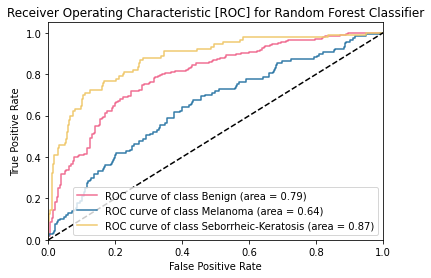

{0: 0.7943162772355319, 1: 0.6435613717771395, 2: 0.8748526522593321}

In [ ]:
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_72_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the saved fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
plot_roc(y_test, y_proba_rf, True, 'Random Forest')

#### *Extra Trees Classifier*

In [ ]:
# -- Extra Trees :  ----------------------------------------------------------
strt = time.time()

extra_tree = ExtraTreesClassifier()  # XT classifier
params_extra_tree = {'n_estimators':[100, 500, 1000, 2000], 'criterion' : ['entropy','gini'], 'max_depth': [3, 5, 7, 9, 13]}  # Parameter to be used in the GridSearchCV
grid_search_xt = GridSearchCV(extra_tree, param_grid=params_extra_tree , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances
grid_search_xt.fit(X_new,y_train)
print('Training best_score_ :',grid_search_xt.best_score_)
print('Best Parameters', grid_search_xt.best_params_)
# Fitting the XT classifier with the best parameters found in the grid search
xtree = ExtraTreesClassifier(n_estimators=grid_search_xt.best_params_['n_estimators'], criterion=grid_search_xt.best_params_['criterion'], max_depth=grid_search_xt.best_params_['max_depth'], bootstrap=False)
xtree.fit(X_new,y_train)
y_pred_xt = xtree.predict(Xt_new)  # Predictions
xtScores = get_prediction_score(y_test, y_pred_xt)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores Extra_Trees classifier :', xtScores)

In [ ]:
# ---  Save the Fitted model and parameters in the Save_Folder :  ----------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
  # # -- Extra_Trees :  ----------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_xt, f)
  # print("grid_search_extra_tree were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_72.best_params_' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_xt.best_params_, f)
  # print("grid_search_extra_tree.best_params_ were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(xtree, f)
  # print("xtree were saved..\n")

* *ROC Curve and AUC values for each class*

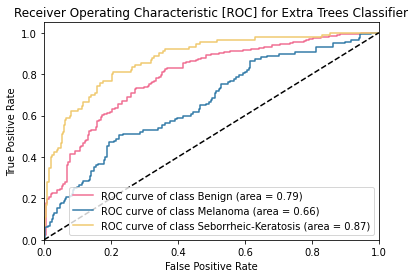

In [ ]:
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_72_new' + '.pkl'), 'rb') as file:
    xt_clf = pickle.load(file)  # Get the saved fitted model
y_pred_xt = xt_clf.predict(Xt_new)
y_proba_xt = xt_clf.predict_proba(Xt_new)
xtAUC = plot_roc(y_test, y_proba_xt, True, 'Extra Trees')

#### *Support Vector Machine [SVM] Classifier*

In [ ]:
# -- SVM :  --------------------------------------------------------------------
strt = time.time()

svc = SVC(probability=True, gamma='auto', kernel = 'rbf', tol=0.001, cache_size=200, class_weight='balanced', random_state=0, decision_function_shape='ovr') 
params_svm = {'C': range(1,11)}  # Parameter to be used in the GridSearchCV
grid_search_svm = GridSearchCV(svc, param_grid=params_svm , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances
grid_search_svm.fit(X_new,y_train)
print('Training best_score_ :',grid_search_svm.best_score_)
print('Best Parameters', grid_search_svm.best_params_)
# Fitting the SVM classifier with the best parameters found in the grid search
svm = SVC(probability=True, gamma='auto', kernel = 'rbf', tol=0.001, cache_size=200, class_weight='balanced', random_state=0, decision_function_shape='ovr', C=grid_search_svm.best_params_['C'])
svm.fit(X_new,y_train)
y_pred_svm = svm.predict(Xt_new)  # Predictions
svmScores = get_prediction_score(y_test, y_pred_svm)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svmScores)

In [ ]:
# ---  Save the Fitted model and parameters in the Save_Folder :  ----------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
  # # -- SVM :  ------------------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_svm, f)
  # print("grid_search_svm were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_72.best_params_' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_svm.best_params_, f)
  # print("grid_search_svm.best_params_ were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(svm, f)
  # print("svm were saved..\n")

* *ROC Curve and AUC values for each class*

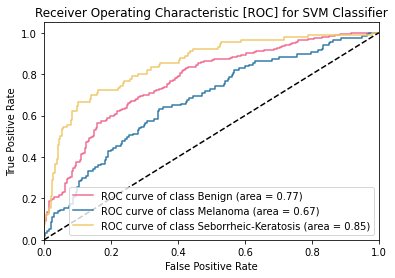

In [ ]:
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_72_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)  # Get the saved fitted model
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, True, 'SVM')

#### *Gradient Boosting Classifier*

In [ ]:
# -- Gradient Boosting :  ----------------------------------------------------
strt = time.time()

gradient_boosting = GradientBoostingClassifier(subsample=0.7, max_features='sqrt', random_state=0)
params_gradient_boosting = {'n_estimators':[100, 500, 1000, 2000], 'max_depth': [3, 5, 7, 9, 13], 'learning_rate': [0.01, 0.1]}  # Parameter to be used in the GridSearchCV
grid_search_gb = GridSearchCV(gradient_boosting, param_grid= params_gradient_boosting, cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances
grid_search_gb.fit(X_new,y_train)
print('Training best_score_ :',grid_search_gb.best_score_)
print('Best Parameters', grid_search_gb.best_params_)
# Fitting the GB classifier with the best parameters found in the grid search
boosting = GradientBoostingClassifier(subsample=0.7, max_features='sqrt', random_state=0, n_estimators=grid_search_gb.best_params_['n_estimators'], max_depth=grid_search_gb.best_params_['max_depth'], learning_rate=grid_search_gb.best_params_['learning_rate'] )
boosting.fit(X_new, y_train)
y_pred_gb = boosting.predict(Xt_new)  # Predictions
gbScores = get_prediction_score(y_test, y_pred_gb)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores Gradient_Boosting classifier :', gbScores)

In [ ]:
# ---  Save the Fitted model and parameters in the Save_Folder :  ----------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
  # # -- Gradient_Boosting :  ----------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_gb, f)
  # print("grid_search_gradient_boosting were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_72.best_params_' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_gb.best_params_, f)
  # print("grid_search_gradient_boosting.best_params_ were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(boosting, f)
  # print("boosting were saved..\n")  


* *ROC Curve and AUC values for each class*

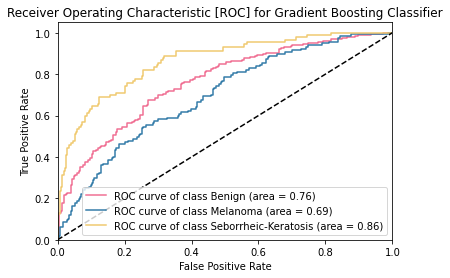

In [ ]:
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_72_wParam' + '.pkl'), 'rb') as file:
    gb_clf = pickle.load(file)  # Get the saved fitted model
y_pred_gb = gb_clf.predict(Xt_new)
y_proba_gb = gb_clf.predict_proba(Xt_new)
gbAUC = plot_roc(y_test, y_proba_gb, True, 'Gradient Boosting')

#### *XGBoost Classifier*

In [ ]:
# -- XGBoost :  --------------------------------------------------------------
strt = time.time()

XGBoost = xgb.XGBClassifier(objective="multi:softmax", num_class=3)
params_XGBoost = {'n_estimators':[100, 500, 1000, 2000], 'max_depth': [3, 5, 7, 9, 13], 'learning_rate': [0.01, 0.1]}  # Parameter to be used in the GridSearchCV
grid_search_xgb = GridSearchCV(XGBoost, param_grid= params_XGBoost, cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances
grid_search_xgb.fit(X_new,y_train)
print('Training best_score_ :',grid_search_xgb.best_score_)
print('Best Parameters', grid_search_xgb.best_params_)
# Fitting the XGB classifier with the best parameters found in the grid search
xgboosting = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search_xgb.best_params_['n_estimators'], max_depth=grid_search_xgb.best_params_['max_depth'], learning_rate=grid_search_xgb.best_params_['learning_rate'] )
xgboosting.fit(X_new, y_train)
y_pred_xgb = xgboosting.predict(Xt_new)  # Predictions
xgbScores = get_prediction_score(y_test, y_pred_xgb)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGBoosting classifier :', xgbScores)

In [ ]:
# ---  Save the Fitted model and parameters in the Save_Folder :  ----------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
  # # -- XGBoosting :  -----------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_xgb, f)
  # print("grid_search_xgboosting_2150_72 were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_72.best_params_' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_xgb.best_params_, f)
  # print("grid_search_xgboosting_2150_72.best_params_ were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(xgboosting, f)
  # print("xgboosting_2150_72 were saved..\n")  

* *ROC Curve and AUC values for each class*

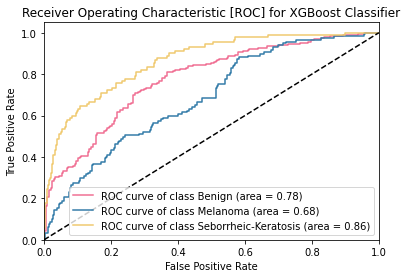

In [ ]:
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_72_new' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)  # Get the saved fitted model
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, True, 'XGBoost')

#### *K-Nearesr Neighbors Classifier*

In [ ]:
# -- KNN :  ------------------------------------------------------------------
strt = time.time()

knn_model = KNeighborsClassifier()
params_knn = {'n_neighbors':[5, 10, 15, 20, 25, 30], 'weights': ['uniform', 'distance']}  # Parameter to be used in the GridSearchCV
grid_search_knn = GridSearchCV(knn_model, param_grid=params_knn , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances
grid_search_knn.fit(X_new,y_train)
print('Training best_score_ :',grid_search_knn.best_score_)
print('Best Parameters', grid_search_knn.best_params_)
# Fitting the KNN classifier with the best parameters found in the grid search
knn = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], weights=grid_search_knn.best_params_['weights'])
knn.fit(X_new,y_train)
y_pred_knn = knn.predict(Xt_new)  # Predictions
knnScores = get_prediction_score(y_test, y_pred_knn)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knnScores)

In [ ]:
# ---  Save the Fitted model and parameters in the Save_Folder :  ----------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
  # # -- KNN :  ------------------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_knn, f)
  # print("grid_search_knn were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_72.best_params_' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_knn.best_params_, f)
  # print("grid_search_knn.best_params_ were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(knn, f)
  # print("knn were saved..\n")

* *ROC Curve and AUC values for each class*

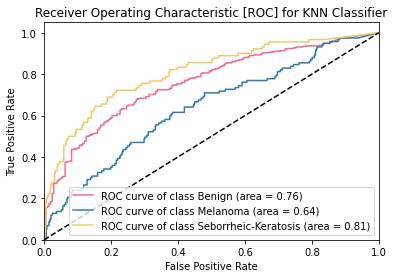

In [ ]:
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_72_new' + '.pkl'), 'rb') as file:
    knn_clf = pickle.load(file)  # Get the saved fitted model
y_pred_knn = knn_clf.predict(Xt_new)
y_proba_knn = knn_clf.predict_proba(Xt_new)
knnAUC = plot_roc(y_test, y_proba_knn, True, 'KNN')

#### *Logistic Regression*

In [ ]:
# -- Logistic Regression :  ----------------------------------------------------
strt = time.time()

lin_model = linear_model.LogisticRegression()
params_lr = {'C': [1.0, 10.0, 100.0, 1000.0], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}  # Parameter to be used in the GridSearchCV
grid_search_lr = GridSearchCV(lin_model, param_grid=params_lr , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances
grid_search_lr.fit(X_new,y_train)
print('Training best_score_ :',grid_search_lr.best_score_)
print(grid_search_lr.best_estimator_)
print('Best Parameters', grid_search_lr.best_params_)
# Fitting the LR classifier with the best parameters found in the grid search
lr = linear_model.LogisticRegression(C=grid_search_lr.best_params_['C'], solver=grid_search_lr.best_params_['solver'])
lr.fit(X_new,y_train)
y_pred_lr = lr.predict(Xt_new)  # Predictions
lrScores = get_prediction_score(y_test, y_pred_lr)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores Logistic_Regression classifier :', lrScores)

In [ ]:
# ---  Save the Fitted model and parameters in the Save_Folder :  ----------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
  # # -- Logistic_Regression :  --------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_lr, f)
  # print("grid_search_lr were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_72.best_params_' + '.pkl'), 'wb') as f:
  #         pickle.dump(grid_search_lr.best_params_, f)
  # print("grid_search_lr.best_params_ were saved..\n")
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(lr, f)
  # print("lr were saved..\n")

* *ROC Curve and AUC values for each class*

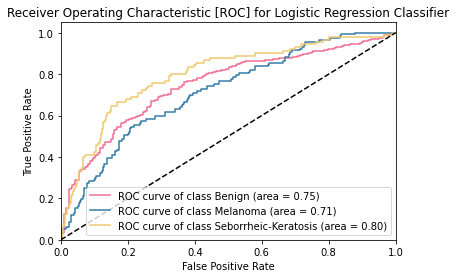

In [ ]:
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_72_noParam' + '.pkl'), 'rb') as file:
    lr_clf = pickle.load(file)  # Get the saved fitted model
y_pred_lr = lr_clf.predict(Xt_new)
y_proba_lr = lr_clf.predict_proba(Xt_new)
lrAUC = plot_roc(y_test, y_proba_lr, True, 'Logistic Regression')

#### *Overall Scores for Each Feature Vector and Classifier*

* *In the following subsections, the overall performances of the previous classifiers for each feature vector combination are presented*

##### *Feature Vector 1 [1x72]*

In [27]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features and labels: ------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 72)


In [28]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'
      
# ---------------------  Read Fitted models and parameters on (2150, 72)  --------------------------
# RF : 
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_72_noParam' + '.pkl'), 'rb') as file:
    grid_search_rf = pickle.load(file)  # Get the model's best parameters
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_72_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
rfAUC = plot_roc(y_test, y_proba_rf, False, 'Random Forest')  # Compute the ROC&AUC
rfAUC = np.reshape([rfAUC[0], rfAUC[1], rfAUC[2]], (3, 1))  # Reshape the AUC score vertically
rfScores = get_prediction_score(y_test, y_pred_rf)  # Get prediction scores

# XT :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_72_new' + '.pkl'), 'rb') as file:
    grid_search_xt = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_72_new' + '.pkl'), 'rb') as file:
    xt_clf = pickle.load(file)
y_pred_xt = xt_clf.predict(Xt_new)
y_proba_xt = xt_clf.predict_proba(Xt_new)
xtAUC = plot_roc(y_test, y_proba_xt, False, 'Extra Trees')
xtAUC = np.reshape([xtAUC[0], xtAUC[1], xtAUC[2]], (3, 1))  
xtScores = get_prediction_score(y_test, y_pred_xt) 

# SVM :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_72_wParam' + '.pkl'), 'rb') as file:
    grid_search_svm = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_72_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, False, 'SVM')
svmAUC = np.reshape([svmAUC[0], svmAUC[1], svmAUC[2]], (3, 1)) 
svmScores = get_prediction_score(y_test, y_pred_svm)  

# GB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_72_wParam' + '.pkl'), 'rb') as file:
    grid_search_gb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_72_wParam' + '.pkl'), 'rb') as file:  #--------
    gb_clf = pickle.load(file)
y_pred_gb = gb_clf.predict(Xt_new)
y_proba_gb = gb_clf.predict_proba(Xt_new)
gbAUC = plot_roc(y_test, y_proba_gb, False, 'Gradient Boosting')
gbAUC = np.reshape([gbAUC[0], gbAUC[1], gbAUC[2]], (3, 1))  
gbScores = get_prediction_score(y_test, y_pred_gb) 

# XGB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_72_new' + '.pkl'), 'rb') as file:
    grid_search_xgb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_72_new' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, False, 'XGBoost')
xgbAUC = np.reshape([xgbAUC[0], xgbAUC[1], xgbAUC[2]], (3, 1))  
xgbScores = get_prediction_score(y_test, y_pred_xgb) 

# KNN :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_72_new' + '.pkl'), 'rb') as file:
    grid_search_knn = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_72_new' + '.pkl'), 'rb') as file:
    knn_clf = pickle.load(file)
y_pred_knn = knn_clf.predict(Xt_new)
y_proba_knn = knn_clf.predict_proba(Xt_new)
knnAUC = plot_roc(y_test, y_proba_knn, False, 'KNN')
knnAUC = np.reshape([knnAUC[0], knnAUC[1], knnAUC[2]], (3, 1))  
knnScores = get_prediction_score(y_test, y_pred_knn) 

# LR :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_72_noParam' + '.pkl'), 'rb') as file:
    grid_search_lr = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_72_noParam' + '.pkl'), 'rb') as file:
    lr_clf = pickle.load(file)
y_pred_lr = lr_clf.predict(Xt_new)
y_proba_lr = lr_clf.predict_proba(Xt_new)
lrAUC = plot_roc(y_test, y_proba_lr, False, 'Logistic Regression')
lrAUC = np.reshape([lrAUC[0], lrAUC[1], lrAUC[2]], (3, 1))  
lrScores = get_prediction_score(y_test, y_pred_lr) 

In [29]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results Feature Vector 1 (1x72) :')
table = [[' ', 'Training Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['Random Forest', grid_search_rf.best_score_, rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'],  rfScores['Recall'], rfAUC, rfScores['Confusion Matrix'] ], 
         ['Extra Trees', grid_search_xt.best_score_, xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtAUC, xtScores['Confusion Matrix'] ], 
         ['SVM', grid_search_svm.best_score_, svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmAUC, svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', grid_search_gb.best_score_, gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbAUC, gbScores['Confusion Matrix'] ],
         ['XGBoosting', grid_search_xgb.best_score_, xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbAUC, xgbScores['Confusion Matrix'] ],
         ['KNN', grid_search_knn.best_score_, knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnAUC, knnScores['Confusion Matrix'] ],
         ['Logistic Regression', grid_search_lr.best_score_, lrScores['Accuracy'], lrScores['Balanced Accuracy'], lrScores['Precision'], lrScores['Recall'], lrAUC, lrScores['Confusion Matrix'] ] 
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results Feature Vector 1 (1x72) :
╒═════════════════════╤══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│                     │  Training Score  │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞═════════════════════╪══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ Random Forest       │     0.850127     │  0.614357  │       0.61404       │   0.57562   │ 0.61404  │ [[0.79431628]  │ [[243 124  25]     │
│                     │                  │            │                     │             │          │  [0.64356137]  │  [ 31  65  21]     │
│                     │                  │            │                     │             │          │  [0.87485265]] │  [ 14  16  60]]    │
├─────────────────────┼──────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼───

##### *Feature Vector 2 [1x92]*

In [30]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features and labels: ------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_92' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_92' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_92' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_92' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 92)


In [31]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'
      
# ---------------------  Read Fitted models and parameters on (2150, 92)  --------------------------
# RF :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_92_noParam' + '.pkl'), 'rb') as file:
    grid_search_rf = pickle.load(file)  # Get the model's best parameters
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_92_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
rfAUC = plot_roc(y_test, y_proba_rf, False, 'Random Forest')  # Compute the ROC&AUC
rfAUC = np.reshape([rfAUC[0], rfAUC[1], rfAUC[2]], (3, 1))  # Reshape the AUC score vertically
rfScores = get_prediction_score(y_test, y_pred_rf)  # Get prediction scores

# XT :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_92_new' + '.pkl'), 'rb') as file:
    grid_search_xt = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_92_new' + '.pkl'), 'rb') as file:
    xt_clf = pickle.load(file)
y_pred_xt = xt_clf.predict(Xt_new)
y_proba_xt = xt_clf.predict_proba(Xt_new)
xtAUC = plot_roc(y_test, y_proba_xt, False, 'Extra Trees')
xtAUC = np.reshape([xtAUC[0], xtAUC[1], xtAUC[2]], (3, 1))  
xtScores = get_prediction_score(y_test, y_pred_xt) 

# SVM :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_92_wParam' + '.pkl'), 'rb') as file:
    grid_search_svm = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_92_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, False, 'SVM')
svmAUC = np.reshape([svmAUC[0], svmAUC[1], svmAUC[2]], (3, 1)) 
svmScores = get_prediction_score(y_test, y_pred_svm)  

# GB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_92_wParam' + '.pkl'), 'rb') as file:
    grid_search_gb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_92_wParam' + '.pkl'), 'rb') as file:  #--------
    gb_clf = pickle.load(file)
y_pred_gb = gb_clf.predict(Xt_new)
y_proba_gb = gb_clf.predict_proba(Xt_new)
gbAUC = plot_roc(y_test, y_proba_gb, False, 'Gradient Boosting')
gbAUC = np.reshape([gbAUC[0], gbAUC[1], gbAUC[2]], (3, 1))  
gbScores = get_prediction_score(y_test, y_pred_gb) 

# XGB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_92_new' + '.pkl'), 'rb') as file:
    grid_search_xgb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_92_new' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, False, 'XGBoost')
xgbAUC = np.reshape([xgbAUC[0], xgbAUC[1], xgbAUC[2]], (3, 1))  
xgbScores = get_prediction_score(y_test, y_pred_xgb) 

# KNN :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_92_new' + '.pkl'), 'rb') as file:
    grid_search_knn = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_92_new' + '.pkl'), 'rb') as file:
    knn_clf = pickle.load(file)
y_pred_knn = knn_clf.predict(Xt_new)
y_proba_knn = knn_clf.predict_proba(Xt_new)
knnAUC = plot_roc(y_test, y_proba_knn, False, 'KNN')
knnAUC = np.reshape([knnAUC[0], knnAUC[1], knnAUC[2]], (3, 1))  
knnScores = get_prediction_score(y_test, y_pred_knn) 

# LR :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_92_noParam' + '.pkl'), 'rb') as file:
    grid_search_lr = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_92_noParam' + '.pkl'), 'rb') as file:
    lr_clf = pickle.load(file)
y_pred_lr = lr_clf.predict(Xt_new)
y_proba_lr = lr_clf.predict_proba(Xt_new)
lrAUC = plot_roc(y_test, y_proba_lr, False, 'Logistic Regression')
lrAUC = np.reshape([lrAUC[0], lrAUC[1], lrAUC[2]], (3, 1))  
lrScores = get_prediction_score(y_test, y_pred_lr) 

In [32]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results Feature Vector 2 (1x92) :')
table = [[' ', 'Training Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['Random Forest', grid_search_rf.best_score_, rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'],  rfScores['Recall'], rfAUC, rfScores['Confusion Matrix'] ], 
         ['Extra Trees', grid_search_xt.best_score_, xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtAUC, xtScores['Confusion Matrix'] ], 
         ['SVM', grid_search_svm.best_score_, svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmAUC, svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', grid_search_gb.best_score_, gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbAUC, gbScores['Confusion Matrix'] ],
         ['XGBoosting', grid_search_xgb.best_score_, xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbAUC, xgbScores['Confusion Matrix'] ],
         ['KNN', grid_search_knn.best_score_, knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnAUC, knnScores['Confusion Matrix'] ],
         ['Logistic Regression', grid_search_lr.best_score_, lrScores['Accuracy'], lrScores['Balanced Accuracy'], lrScores['Precision'], lrScores['Recall'], lrAUC, lrScores['Confusion Matrix'] ] 
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results Feature Vector 2 (1x92) :
╒═════════════════════╤══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│                     │  Training Score  │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞═════════════════════╪══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ Random Forest       │     0.845047     │  0.594324  │       0.60498       │  0.559723   │ 0.60498  │ [[0.78212807]  │ [[230 129  33]     │
│                     │                  │            │                     │             │          │  [0.66081498]  │  [ 29  67  21]     │
│                     │                  │            │                     │             │          │  [0.86856582]] │  [ 14  17  59]]    │
├─────────────────────┼──────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼───

##### *Feature Vector 3 [1x457]*

In [33]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features and labels: ------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_457' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_457' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_457' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_457' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 457)


In [34]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'
      
# ---------------------  Read Fitted models and parameters on (2150, 457)  --------------------------
# RF :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_457_noParam' + '.pkl'), 'rb') as file:
    grid_search_rf = pickle.load(file)  # Get the model's best parameters
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_457_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
rfAUC = plot_roc(y_test, y_proba_rf, False, 'Random Forest')  # Compute the ROC&AUC
rfAUC = np.reshape([rfAUC[0], rfAUC[1], rfAUC[2]], (3, 1))  # Reshape the AUC score vertically
rfScores = get_prediction_score(y_test, y_pred_rf)  # Get prediction scores

# XT :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_457' + '.pkl'), 'rb') as file:
    grid_search_xt = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_457' + '.pkl'), 'rb') as file:
    xt_clf = pickle.load(file)
y_pred_xt = xt_clf.predict(Xt_new)
y_proba_xt = xt_clf.predict_proba(Xt_new)
xtAUC = plot_roc(y_test, y_proba_xt, False, 'Extra Trees')
xtAUC = np.reshape([xtAUC[0], xtAUC[1], xtAUC[2]], (3, 1))  
xtScores = get_prediction_score(y_test, y_pred_xt) 

# SVM :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_457_wParam' + '.pkl'), 'rb') as file:
    grid_search_svm = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_457_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, False, 'SVM')
svmAUC = np.reshape([svmAUC[0], svmAUC[1], svmAUC[2]], (3, 1)) 
svmScores = get_prediction_score(y_test, y_pred_svm)  

# GB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_457_wParam' + '.pkl'), 'rb') as file:
    grid_search_gb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_457_wParam' + '.pkl'), 'rb') as file:  #--------
    gb_clf = pickle.load(file)
y_pred_gb = gb_clf.predict(Xt_new)
y_proba_gb = gb_clf.predict_proba(Xt_new)
gbAUC = plot_roc(y_test, y_proba_gb, False, 'Gradient Boosting')
gbAUC = np.reshape([gbAUC[0], gbAUC[1], gbAUC[2]], (3, 1))  
gbScores = get_prediction_score(y_test, y_pred_gb) 

# XGB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_457' + '.pkl'), 'rb') as file:
    grid_search_xgb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_457' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, False, 'XGBoost')
xgbAUC = np.reshape([xgbAUC[0], xgbAUC[1], xgbAUC[2]], (3, 1))  
xgbScores = get_prediction_score(y_test, y_pred_xgb) 

# KNN :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_457' + '.pkl'), 'rb') as file:
    grid_search_knn = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_457' + '.pkl'), 'rb') as file:
    knn_clf = pickle.load(file)
y_pred_knn = knn_clf.predict(Xt_new)
y_proba_knn = knn_clf.predict_proba(Xt_new)
knnAUC = plot_roc(y_test, y_proba_knn, False, 'KNN')
knnAUC = np.reshape([knnAUC[0], knnAUC[1], knnAUC[2]], (3, 1))  
knnScores = get_prediction_score(y_test, y_pred_knn) 

# LR :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_457_noParam' + '.pkl'), 'rb') as file:
    grid_search_lr = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_457_noParam' + '.pkl'), 'rb') as file:
    lr_clf = pickle.load(file)
y_pred_lr = lr_clf.predict(Xt_new)
y_proba_lr = lr_clf.predict_proba(Xt_new)
lrAUC = plot_roc(y_test, y_proba_lr, False, 'Logistic Regression')
lrAUC = np.reshape([lrAUC[0], lrAUC[1], lrAUC[2]], (3, 1))  
lrScores = get_prediction_score(y_test, y_pred_lr) 

In [35]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results Feature Vector 3 (1x457) :')
table = [[' ', 'Training Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['Random Forest', grid_search_rf.best_score_, rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'],  rfScores['Recall'], rfAUC, rfScores['Confusion Matrix'] ], 
         ['Extra Trees', grid_search_xt.best_score_, xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtAUC, xtScores['Confusion Matrix'] ], 
         ['SVM', grid_search_svm.best_score_, svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmAUC, svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', grid_search_gb.best_score_, gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbAUC, gbScores['Confusion Matrix'] ],
         ['XGBoosting', grid_search_xgb.best_score_, xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbAUC, xgbScores['Confusion Matrix'] ],
         ['KNN', grid_search_knn.best_score_, knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnAUC, knnScores['Confusion Matrix'] ],
         ['Logistic Regression', grid_search_lr.best_score_, lrScores['Accuracy'], lrScores['Balanced Accuracy'], lrScores['Precision'], lrScores['Recall'], lrAUC, lrScores['Confusion Matrix'] ] 
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results Feature Vector 3 (1x457) :
╒═════════════════════╤══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│                     │  Training Score  │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞═════════════════════╪══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ Random Forest       │     0.85085      │  0.644407  │      0.597959       │  0.579612   │ 0.597959 │ [[0.7862935 ]  │ [[272  99  21]     │
│                     │                  │            │                     │             │          │  [0.63414548]  │  [ 33  65  19]     │
│                     │                  │            │                     │             │          │  [0.85852434]] │  [ 20  21  49]]    │
├─────────────────────┼──────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼──

##### *Feature Vector 4 [1x385]*

In [36]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features and labels: ------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_385_shapeFt' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_385_shapeFt' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_385_shapeFt' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_385_shapeFt' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 385)


In [37]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'
      
# ---------------------  Read Fitted models and parameters on (2150, 385)  --------------------------
# RF :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_385_noParam' + '.pkl'), 'rb') as file:
    grid_search_rf = pickle.load(file)  # Get the model's best parameters
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_385_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
rfAUC = plot_roc(y_test, y_proba_rf, False, 'Random Forest')  # Compute the ROC&AUC
rfAUC = np.reshape([rfAUC[0], rfAUC[1], rfAUC[2]], (3, 1))  # Reshape the AUC score vertically
rfScores = get_prediction_score(y_test, y_pred_rf)  # Get prediction scores

# XT :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_385_shapeFt' + '.pkl'), 'rb') as file:
    grid_search_xt = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_385_shapeFt' + '.pkl'), 'rb') as file:
    xt_clf = pickle.load(file)
y_pred_xt = xt_clf.predict(Xt_new)
y_proba_xt = xt_clf.predict_proba(Xt_new)
xtAUC = plot_roc(y_test, y_proba_xt, False, 'Extra Trees')
xtAUC = np.reshape([xtAUC[0], xtAUC[1], xtAUC[2]], (3, 1))  
xtScores = get_prediction_score(y_test, y_pred_xt) 

# SVM :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_385_wParam' + '.pkl'), 'rb') as file:
    grid_search_svm = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_385_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, False, 'SVM')
svmAUC = np.reshape([svmAUC[0], svmAUC[1], svmAUC[2]], (3, 1)) 
svmScores = get_prediction_score(y_test, y_pred_svm)  

# GB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_385_wParam' + '.pkl'), 'rb') as file:
    grid_search_gb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_385_wParam' + '.pkl'), 'rb') as file:  #--------
    gb_clf = pickle.load(file)
y_pred_gb = gb_clf.predict(Xt_new)
y_proba_gb = gb_clf.predict_proba(Xt_new)
gbAUC = plot_roc(y_test, y_proba_gb, False, 'Gradient Boosting')
gbAUC = np.reshape([gbAUC[0], gbAUC[1], gbAUC[2]], (3, 1))  
gbScores = get_prediction_score(y_test, y_pred_gb) 

# XGB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_385_wParam' + '.pkl'), 'rb') as file:
    grid_search_xgb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_385_wParam' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, False, 'XGBoost')
xgbAUC = np.reshape([xgbAUC[0], xgbAUC[1], xgbAUC[2]], (3, 1))  
xgbScores = get_prediction_score(y_test, y_pred_xgb) 

# KNN :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_385_shapeFt' + '.pkl'), 'rb') as file:
    grid_search_knn = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_385_shapeFt' + '.pkl'), 'rb') as file:
    knn_clf = pickle.load(file)
y_pred_knn = knn_clf.predict(Xt_new)
y_proba_knn = knn_clf.predict_proba(Xt_new)
knnAUC = plot_roc(y_test, y_proba_knn, False, 'KNN')
knnAUC = np.reshape([knnAUC[0], knnAUC[1], knnAUC[2]], (3, 1))  
knnScores = get_prediction_score(y_test, y_pred_knn) 

# LR :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_385_noParam' + '.pkl'), 'rb') as file:
    grid_search_lr = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_385_noParam' + '.pkl'), 'rb') as file:
    lr_clf = pickle.load(file)
y_pred_lr = lr_clf.predict(Xt_new)
y_proba_lr = lr_clf.predict_proba(Xt_new)
lrAUC = plot_roc(y_test, y_proba_lr, False, 'Logistic Regression')
lrAUC = np.reshape([lrAUC[0], lrAUC[1], lrAUC[2]], (3, 1))  
lrScores = get_prediction_score(y_test, y_pred_lr) 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results Feature Vector 4 (1x385) :')
table = [[' ', 'Training Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['Random Forest', grid_search_rf.best_score_, rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'],  rfScores['Recall'], rfAUC, rfScores['Confusion Matrix'] ], 
         ['Extra Trees', grid_search_xt.best_score_, xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtAUC, xtScores['Confusion Matrix'] ], 
         ['SVM', grid_search_svm.best_score_, svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmAUC, svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', grid_search_gb.best_score_, gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbAUC, gbScores['Confusion Matrix'] ],
         ['XGBoosting', grid_search_xgb.best_score_, xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbAUC, xgbScores['Confusion Matrix'] ],
         ['KNN', grid_search_knn.best_score_, knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnAUC, knnScores['Confusion Matrix'] ],
         ['Logistic Regression', grid_search_lr.best_score_, lrScores['Accuracy'], lrScores['Balanced Accuracy'], lrScores['Precision'], lrScores['Recall'], lrAUC, lrScores['Confusion Matrix'] ] 
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results Feature Vector 4 (1x385) :
╒═════════════════════╤══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│                     │  Training Score  │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞═════════════════════╪══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ Random Forest       │     0.857515     │  0.649416  │      0.333636       │  0.256618   │ 0.333636 │ [[0.63331854]  │ [[388   1   3]     │
│                     │                  │            │                     │             │          │  [0.57740185]  │  [112   0   5]     │
│                     │                  │            │                     │             │          │  [0.64261078]] │  [ 89   0   1]]    │
├─────────────────────┼──────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼──

##### *Feature Vector 5 [1x59]*

In [39]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features and labels: ------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_59_textureFt' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_59_textureFt' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_59_textureFt' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_59_textureFt' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 59)


In [40]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'
      
# ---------------------  Read Fitted models and parameters on (2150, 59)  --------------------------
# RF :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_59_noParam' + '.pkl'), 'rb') as file:
    grid_search_rf = pickle.load(file)  # Get the model's best parameters
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_59_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
rfAUC = plot_roc(y_test, y_proba_rf, False, 'Random Forest')  # Compute the ROC&AUC
rfAUC = np.reshape([rfAUC[0], rfAUC[1], rfAUC[2]], (3, 1))  # Reshape the AUC score vertically
rfScores = get_prediction_score(y_test, y_pred_rf)  # Get prediction scores

# XT :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_59_textureFt' + '.pkl'), 'rb') as file:
    grid_search_xt = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_59_textureFt' + '.pkl'), 'rb') as file:
    xt_clf = pickle.load(file)
y_pred_xt = xt_clf.predict(Xt_new)
y_proba_xt = xt_clf.predict_proba(Xt_new)
xtAUC = plot_roc(y_test, y_proba_xt, False, 'Extra Trees')
xtAUC = np.reshape([xtAUC[0], xtAUC[1], xtAUC[2]], (3, 1))  
xtScores = get_prediction_score(y_test, y_pred_xt) 

# SVM :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_59_wParam' + '.pkl'), 'rb') as file:
    grid_search_svm = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_59_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, False, 'SVM')
svmAUC = np.reshape([svmAUC[0], svmAUC[1], svmAUC[2]], (3, 1)) 
svmScores = get_prediction_score(y_test, y_pred_svm)  

# GB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_59_wParam' + '.pkl'), 'rb') as file:
    grid_search_gb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_59_wParam' + '.pkl'), 'rb') as file:  #--------
    gb_clf = pickle.load(file)
y_pred_gb = gb_clf.predict(Xt_new)
y_proba_gb = gb_clf.predict_proba(Xt_new)
gbAUC = plot_roc(y_test, y_proba_gb, False, 'Gradient Boosting')
gbAUC = np.reshape([gbAUC[0], gbAUC[1], gbAUC[2]], (3, 1))  
gbScores = get_prediction_score(y_test, y_pred_gb) 

# XGB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_59_textureFt' + '.pkl'), 'rb') as file:
    grid_search_xgb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_59_textureFt' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, False, 'XGBoost')
xgbAUC = np.reshape([xgbAUC[0], xgbAUC[1], xgbAUC[2]], (3, 1))  
xgbScores = get_prediction_score(y_test, y_pred_xgb) 

# KNN :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_59_textureFt' + '.pkl'), 'rb') as file:
    grid_search_knn = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_59_textureFt' + '.pkl'), 'rb') as file:
    knn_clf = pickle.load(file)
y_pred_knn = knn_clf.predict(Xt_new)
y_proba_knn = knn_clf.predict_proba(Xt_new)
knnAUC = plot_roc(y_test, y_proba_knn, False, 'KNN')
knnAUC = np.reshape([knnAUC[0], knnAUC[1], knnAUC[2]], (3, 1))  
knnScores = get_prediction_score(y_test, y_pred_knn) 

# LR :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_59_noParam' + '.pkl'), 'rb') as file:
    grid_search_lr = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_59_noParam' + '.pkl'), 'rb') as file:
    lr_clf = pickle.load(file)
y_pred_lr = lr_clf.predict(Xt_new)
y_proba_lr = lr_clf.predict_proba(Xt_new)
lrAUC = plot_roc(y_test, y_proba_lr, False, 'Logistic Regression')
lrAUC = np.reshape([lrAUC[0], lrAUC[1], lrAUC[2]], (3, 1))  
lrScores = get_prediction_score(y_test, y_pred_lr) 

In [41]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results Feature Vector 5 (1x59) :')
table = [[' ', 'Training Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['Random Forest', grid_search_rf.best_score_, rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'],  rfScores['Recall'], rfAUC, rfScores['Confusion Matrix'] ], 
         ['Extra Trees', grid_search_xt.best_score_, xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtAUC, xtScores['Confusion Matrix'] ], 
         ['SVM', grid_search_svm.best_score_, svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmAUC, svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', grid_search_gb.best_score_, gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbAUC, gbScores['Confusion Matrix'] ],
         ['XGBoosting', grid_search_xgb.best_score_, xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbAUC, xgbScores['Confusion Matrix'] ],
         ['KNN', grid_search_knn.best_score_, knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnAUC, knnScores['Confusion Matrix'] ],
         ['Logistic Regression', grid_search_lr.best_score_, lrScores['Accuracy'], lrScores['Balanced Accuracy'], lrScores['Precision'], lrScores['Recall'], lrAUC, lrScores['Confusion Matrix'] ] 
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results Feature Vector 5 (1x59) :
╒═════════════════════╤══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│                     │  Training Score  │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞═════════════════════╪══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ Random Forest       │     0.827854     │  0.609349  │      0.608359       │  0.581194   │ 0.608359 │ [[0.77095041]  │ [[239 129  24]     │
│                     │                  │            │                     │             │          │  [0.67462851]  │  [ 30  72  15]     │
│                     │                  │            │                     │             │          │  [0.87738485]] │  [ 17  19  54]]    │
├─────────────────────┼──────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼───

##### *Feature Vector 6 [1x2319]*

In [42]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features and labels: ------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_2319_colorFt' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_2319_colorFt' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_2319_colorFt' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_2319_colorFt' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
    ("Univariate Selection", PCA(0.99))  # Feature Selection
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 237)


In [43]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'
      
# ---------------------  Read Fitted models and parameters on (2150, 2319)  --------------------------
# RF :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_2319_noParam' + '.pkl'), 'rb') as file:
    grid_search_rf = pickle.load(file)  # Get the model's best parameters
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_2319_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
rfAUC = plot_roc(y_test, y_proba_rf, False, 'Random Forest')  # Compute the ROC&AUC
rfAUC = np.reshape([rfAUC[0], rfAUC[1], rfAUC[2]], (3, 1))  # Reshape the AUC score vertically
rfScores = get_prediction_score(y_test, y_pred_rf)  # Get prediction scores

# XT :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_2319_colorFt_pca' + '.pkl'), 'rb') as file:
    grid_search_xt = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_2319_colorFt_pca' + '.pkl'), 'rb') as file:
    xt_clf = pickle.load(file)
y_pred_xt = xt_clf.predict(Xt_new)
y_proba_xt = xt_clf.predict_proba(Xt_new)
xtAUC = plot_roc(y_test, y_proba_xt, False, 'Extra Trees')
xtAUC = np.reshape([xtAUC[0], xtAUC[1], xtAUC[2]], (3, 1))  
xtScores = get_prediction_score(y_test, y_pred_xt) 

# SVM :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_2319_wParam' + '.pkl'), 'rb') as file:
    grid_search_svm = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_2319_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, False, 'SVM')
svmAUC = np.reshape([svmAUC[0], svmAUC[1], svmAUC[2]], (3, 1)) 
svmScores = get_prediction_score(y_test, y_pred_svm)  

# GB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_2319_wParam' + '.pkl'), 'rb') as file:
    grid_search_gb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_2319_wParam' + '.pkl'), 'rb') as file:  #--------
    gb_clf = pickle.load(file)
y_pred_gb = gb_clf.predict(Xt_new)
y_proba_gb = gb_clf.predict_proba(Xt_new)
gbAUC = plot_roc(y_test, y_proba_gb, False, 'Gradient Boosting')
gbAUC = np.reshape([gbAUC[0], gbAUC[1], gbAUC[2]], (3, 1))  
gbScores = get_prediction_score(y_test, y_pred_gb) 

# XGB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_2319_colorFt_pca' + '.pkl'), 'rb') as file:
    grid_search_xgb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_2319_colorFt_pca' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, False, 'XGBoost')
xgbAUC = np.reshape([xgbAUC[0], xgbAUC[1], xgbAUC[2]], (3, 1))  
xgbScores = get_prediction_score(y_test, y_pred_xgb) 

# KNN :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_2319_colorFt_pca' + '.pkl'), 'rb') as file:
    grid_search_knn = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_2319_colorFt_pca' + '.pkl'), 'rb') as file:
    knn_clf = pickle.load(file)
y_pred_knn = knn_clf.predict(Xt_new)
y_proba_knn = knn_clf.predict_proba(Xt_new)
knnAUC = plot_roc(y_test, y_proba_knn, False, 'KNN')
knnAUC = np.reshape([knnAUC[0], knnAUC[1], knnAUC[2]], (3, 1))  
knnScores = get_prediction_score(y_test, y_pred_knn) 

# LR :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_2319_noParam' + '.pkl'), 'rb') as file:
    grid_search_lr = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_2319_noParam' + '.pkl'), 'rb') as file:
    lr_clf = pickle.load(file)
y_pred_lr = lr_clf.predict(Xt_new)
y_proba_lr = lr_clf.predict_proba(Xt_new)
lrAUC = plot_roc(y_test, y_proba_lr, False, 'Logistic Regression')
lrAUC = np.reshape([lrAUC[0], lrAUC[1], lrAUC[2]], (3, 1))  
lrScores = get_prediction_score(y_test, y_pred_lr) 

In [44]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results Feature Vector 6 (1x2319) :')
table = [[' ', 'Training Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['Random Forest', grid_search_rf.best_score_, rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'],  rfScores['Recall'], rfAUC, rfScores['Confusion Matrix'] ], 
         ['Extra Trees', grid_search_xt.best_score_, xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtAUC, xtScores['Confusion Matrix'] ], 
         ['SVM', grid_search_svm.best_score_, svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmAUC, svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', grid_search_gb.best_score_, gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbAUC, gbScores['Confusion Matrix'] ],
         ['XGBoosting', grid_search_xgb.best_score_, xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbAUC, xgbScores['Confusion Matrix'] ],
         ['KNN', grid_search_knn.best_score_, knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnAUC, knnScores['Confusion Matrix'] ],
         ['Logistic Regression', grid_search_lr.best_score_, lrScores['Accuracy'], lrScores['Balanced Accuracy'], lrScores['Precision'], lrScores['Recall'], lrAUC, lrScores['Confusion Matrix'] ] 
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results Feature Vector 6 (1x2319) :
╒═════════════════════╤══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│                     │  Training Score  │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞═════════════════════╪══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ Random Forest       │     0.839683     │  0.661102  │      0.466004       │  0.474717   │ 0.466004 │ [[0.74392438]  │ [[348  21  23]     │
│                     │                  │            │                     │             │          │  [0.51672164]  │  [ 83   9  25]     │
│                     │                  │            │                     │             │          │  [0.79930146]] │  [ 44   7  39]]    │
├─────────────────────┼──────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼─

##### *Feature Vector 7 [1x9]*

In [45]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features and labels: ------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_9_globalFt' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_9_globalFt' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_9_globalFt' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_9_globalFt' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 9)


In [46]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'
      
# ---------------------  Read Fitted models parameters on (2150, 9)  --------------------------
# RF :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_9_noParam' + '.pkl'), 'rb') as file:
    grid_search_rf = pickle.load(file)  # Get the model's best parameters
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_9_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
rfAUC = plot_roc(y_test, y_proba_rf, False, 'Random Forest')  # Compute the ROC&AUC
rfAUC = np.reshape([rfAUC[0], rfAUC[1], rfAUC[2]], (3, 1))  # Reshape the AUC score vertically
rfScores = get_prediction_score(y_test, y_pred_rf)  # Get prediction scores

# XT :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_extra_tree_2150_9_globalFt' + '.pkl'), 'rb') as file:
    grid_search_xt = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_9_globalFt' + '.pkl'), 'rb') as file:
    xt_clf = pickle.load(file)
y_pred_xt = xt_clf.predict(Xt_new)
y_proba_xt = xt_clf.predict_proba(Xt_new)
xtAUC = plot_roc(y_test, y_proba_xt, False, 'Extra Trees')
xtAUC = np.reshape([xtAUC[0], xtAUC[1], xtAUC[2]], (3, 1))  
xtScores = get_prediction_score(y_test, y_pred_xt) 

# SVM :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_9_wParam' + '.pkl'), 'rb') as file:
    grid_search_svm = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_9_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, False, 'SVM')
svmAUC = np.reshape([svmAUC[0], svmAUC[1], svmAUC[2]], (3, 1)) 
svmScores = get_prediction_score(y_test, y_pred_svm)  

# GB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_gradient_boosting_2150_9_wParam' + '.pkl'), 'rb') as file:
    grid_search_gb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_9_wParam' + '.pkl'), 'rb') as file:  #--------
    gb_clf = pickle.load(file)
y_pred_gb = gb_clf.predict(Xt_new)
y_proba_gb = gb_clf.predict_proba(Xt_new)
gbAUC = plot_roc(y_test, y_proba_gb, False, 'Gradient Boosting')
gbAUC = np.reshape([gbAUC[0], gbAUC[1], gbAUC[2]], (3, 1))  
gbScores = get_prediction_score(y_test, y_pred_gb) 

# XGB :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_9_globalFt' + '.pkl'), 'rb') as file:
    grid_search_xgb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_9_globalFt' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, False, 'XGBoost')
xgbAUC = np.reshape([xgbAUC[0], xgbAUC[1], xgbAUC[2]], (3, 1))  
xgbScores = get_prediction_score(y_test, y_pred_xgb) 

# KNN :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_knn_2150_9_globalFt' + '.pkl'), 'rb') as file:
    grid_search_knn = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_9_globalFt' + '.pkl'), 'rb') as file:
    knn_clf = pickle.load(file)
y_pred_knn = knn_clf.predict(Xt_new)
y_proba_knn = knn_clf.predict_proba(Xt_new)
knnAUC = plot_roc(y_test, y_proba_knn, False, 'KNN')
knnAUC = np.reshape([knnAUC[0], knnAUC[1], knnAUC[2]], (3, 1))  
knnScores = get_prediction_score(y_test, y_pred_knn) 

# LR :
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_lr_2150_9_noParam' + '.pkl'), 'rb') as file:
    grid_search_lr = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_9_noParam' + '.pkl'), 'rb') as file:
    lr_clf = pickle.load(file)
y_pred_lr = lr_clf.predict(Xt_new)
y_proba_lr = lr_clf.predict_proba(Xt_new)
lrAUC = plot_roc(y_test, y_proba_lr, False, 'Logistic Regression')
lrAUC = np.reshape([lrAUC[0], lrAUC[1], lrAUC[2]], (3, 1))  
lrScores = get_prediction_score(y_test, y_pred_lr) 

In [47]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results Feature Vector 7 (1x9) :')
table = [[' ', 'Training Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['Random Forest', grid_search_rf.best_score_, rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'],  rfScores['Recall'], rfAUC, rfScores['Confusion Matrix'] ], 
         ['Extra Trees', grid_search_xt.best_score_, xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtAUC, xtScores['Confusion Matrix'] ], 
         ['SVM', grid_search_svm.best_score_, svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmAUC, svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', grid_search_gb.best_score_, gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbAUC, gbScores['Confusion Matrix'] ],
         ['XGBoosting', grid_search_xgb.best_score_, xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbAUC, xgbScores['Confusion Matrix'] ],
         ['KNN', grid_search_knn.best_score_, knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnAUC, knnScores['Confusion Matrix'] ],
         ['Logistic Regression', grid_search_lr.best_score_, lrScores['Accuracy'], lrScores['Balanced Accuracy'], lrScores['Precision'], lrScores['Recall'], lrAUC, lrScores['Confusion Matrix'] ] 
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results Feature Vector 7 (1x9) :
╒═════════════════════╤══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│                     │  Training Score  │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞═════════════════════╪══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ Random Forest       │     0.815989     │  0.567613  │      0.448102       │  0.453768   │ 0.448102 │ [[0.70906044]  │ [[272  95  25]     │
│                     │                  │            │                     │             │          │  [0.56263078]  │  [ 52  41  24]     │
│                     │                  │            │                     │             │          │  [0.76604453]] │  [ 38  25  27]]    │
├─────────────────────┼──────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────

###*Stacking Base Models with Meta Classifier*

* *in this approach, several models are stacked and used with a LR meta-classifier to fit the data and make predictions on the test set*

In [50]:
# ---------------------  Feature vector 1 (2150, 72)  --------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# --- Read Train Features : ----------------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)  

# --- Read Fitted models : -----------------------------------------------------
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_72_noParam' + '.pkl'), 'rb') as file:
    rfClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_72_new' + '.pkl'), 'rb') as file:
    xtClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_72_wParam' + '.pkl'), 'rb') as file: 
    svmClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_72_wParam' + '.pkl'), 'rb') as file:  
    gbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_72_new' + '.pkl'), 'rb') as file:
    xgbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_72_new' + '.pkl'), 'rb') as file:
    knnClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_72_noParam' + '.pkl'), 'rb') as file:
    lrClf = pickle.load(file)

In [51]:
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
    # ("Univariate Selection", PCA(0.99))  # Feature Selection
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)

X_train Shape : (2150, 72)


#### *Stacking Classifiers*

In [ ]:
# ---  Using the Saved Fitted Models as Base Models for the 2nd level Classifier (Meta_Clf) : 

# Kfold cross validation for stacking classifiers
kf = KFold(n_splits=5, shuffle = True)

# classifiers = [svmClf, rfClf, xgbClf]
# classifiers = [svmClf, rfClf, xtClf]
# classifiers = [svmClf, rfClf, xtClf, xgbClf]
# classifiers = [svmClf, rfClf]
classifiers = [svmClf, xtClf, xgbClf] 
# classifiers = [rfClf, xtClf, xgbClf]
# classifiers = [svmClf, xtClf]
# classifiers = [svmClf, xgbClf]
# classifiers = [rfClf, xtClf]
# classifiers = [rfClf, xgbClf] 
# classifiers = [xtClf, xgbClf]
# classifiers = [svmClf, rfClf, xtClf, knnClf] 
# classifiers = [svmClf, rfClf, xtClf, gbClf]
# classifiers = [svmClf, gbClf]
# classifiers = [rfClf, gbClf]

meta_clf = lrClf  # Using LR fitted model as the meta-classifier
stacking_clf = StackingCVClassifier(classifiers=classifiers, 
                                    meta_classifier=meta_clf, cv=kf, use_features_in_secondary=True)

stacking_clf.fit(X_new, y_train)
y_pred = stacking_clf.predict(Xt_new)  # Predictions
print("Accuracy for Stacked classifiers :", get_prediction_score(y_test, y_pred))
print("Balanced Accuracy for Stacked classifiers :", balanced_accuracy_score(y_test, y_pred))

Accuracy for Stacked classifiers : {'Accuracy': 0.6360601001669449, 'Balanced Accuracy': 0.5988487702773417, 'Precision': 0.588692480359147, 'Recall': 0.5988487702773417, 'Confusion Matrix': array([[264, 110,  18],
       [ 33,  69,  15],
       [ 23,  19,  48]])}
Balanced Accuracy for Stacked classifiers : 0.5988487702773417


In [ ]:
# ---  Save the Fitted models in the Save_Folder :  ----------------------------

save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
  # # -- Stacking Classifier :  --------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__4' + '.pkl'), 'wb') as f:
  #         pickle.dump(stacking_clf, f)
  # print("Stacked model was saved..\n")


#### *Overall Results*

In [52]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---------------------  Fitted models on (2150, 72)  --------------------------
with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__1' + '.pkl'), 'rb') as file:
    stacking_clf1_ = pickle.load(file)
y_pred_1 = stacking_clf1_.predict(Xt_new)
y_proba_1 = stacking_clf1_.predict_proba(Xt_new)  # Prediction probability
clf1_AUC = plot_roc(y_test, y_proba_1, False, '-')  # Compute the ROC&AUC
clf1_AUC = np.reshape([clf1_AUC[0], clf1_AUC[1], clf1_AUC[2]], (3, 1))  # Reshape the AUC score vertically
scores1 = get_prediction_score(y_test, y_pred_1)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__2' + '.pkl'), 'rb') as file:
    stacking_clf2_ = pickle.load(file)
y_pred_2 = stacking_clf2_.predict(Xt_new)
y_proba_2 = stacking_clf2_.predict_proba(Xt_new)  
clf2_AUC = plot_roc(y_test, y_proba_2, False, '-')  
clf2_AUC = np.reshape([clf2_AUC[0], clf2_AUC[1], clf2_AUC[2]], (3, 1))
scores2 = get_prediction_score(y_test, y_pred_2)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__3' + '.pkl'), 'rb') as file:
    stacking_clf3_ = pickle.load(file)
y_pred_3 = stacking_clf3_.predict(Xt_new)
y_proba_3 = stacking_clf3_.predict_proba(Xt_new)  
clf3_AUC = plot_roc(y_test, y_proba_3, False, '-')  
clf3_AUC = np.reshape([clf3_AUC[0], clf3_AUC[1], clf3_AUC[2]], (3, 1))
scores3 = get_prediction_score(y_test, y_pred_3)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__4_lr' + '.pkl'), 'rb') as file:
    stacking_clf4_ = pickle.load(file)
y_pred_4 = stacking_clf4_.predict(Xt_new)
y_proba_4 = stacking_clf4_.predict_proba(Xt_new)  
clf4_AUC = plot_roc(y_test, y_proba_4, False, '-')  
clf4_AUC = np.reshape([clf4_AUC[0], clf4_AUC[1], clf4_AUC[2]], (3, 1))
scores4 = get_prediction_score(y_test, y_pred_4)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__5' + '.pkl'), 'rb') as file:
    stacking_clf5_ = pickle.load(file)
y_pred_5 = stacking_clf5_.predict(Xt_new)
y_proba_5 = stacking_clf5_.predict_proba(Xt_new)  
clf5_AUC = plot_roc(y_test, y_proba_5, False, '-')  
clf5_AUC = np.reshape([clf5_AUC[0], clf5_AUC[1], clf5_AUC[2]], (3, 1))
scores5 = get_prediction_score(y_test, y_pred_5)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__6' + '.pkl'), 'rb') as file:
    stacking_clf6_ = pickle.load(file)
y_pred_6 = stacking_clf6_.predict(Xt_new)
y_proba_6 = stacking_clf6_.predict_proba(Xt_new)  
clf6_AUC = plot_roc(y_test, y_proba_6, False, '-')  
clf6_AUC = np.reshape([clf6_AUC[0], clf6_AUC[1], clf6_AUC[2]], (3, 1))
scores6 = get_prediction_score(y_test, y_pred_6)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__7' + '.pkl'), 'rb') as file:
    stacking_clf7_ = pickle.load(file)
y_pred_7 = stacking_clf7_.predict(Xt_new)
y_proba_7 = stacking_clf7_.predict_proba(Xt_new)  
clf7_AUC = plot_roc(y_test, y_proba_7, False, '-')  
clf7_AUC = np.reshape([clf7_AUC[0], clf7_AUC[1], clf7_AUC[2]], (3, 1))
scores7 = get_prediction_score(y_test, y_pred_7)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__8' + '.pkl'), 'rb') as file:
    stacking_clf8_ = pickle.load(file)
y_pred_8 = stacking_clf8_.predict(Xt_new)
y_proba_8 = stacking_clf8_.predict_proba(Xt_new)  
clf8_AUC = plot_roc(y_test, y_proba_8, False, '-')  
clf8_AUC = np.reshape([clf8_AUC[0], clf8_AUC[1], clf8_AUC[2]], (3, 1))
scores8 = get_prediction_score(y_test, y_pred_8)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__9' + '.pkl'), 'rb') as file:
    stacking_clf9_ = pickle.load(file)
y_pred_9 = stacking_clf9_.predict(Xt_new)
y_proba_9 = stacking_clf9_.predict_proba(Xt_new)  
clf9_AUC = plot_roc(y_test, y_proba_9, False, '-')  
clf9_AUC = np.reshape([clf9_AUC[0], clf9_AUC[1], clf9_AUC[2]], (3, 1))
scores9 = get_prediction_score(y_test, y_pred_9)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__10' + '.pkl'), 'rb') as file:
    stacking_clf10_ = pickle.load(file)
y_pred_10 = stacking_clf10_.predict(Xt_new)
y_proba_10 = stacking_clf10_.predict_proba(Xt_new)  
clf10_AUC = plot_roc(y_test, y_proba_10, False, '-')  
clf10_AUC = np.reshape([clf10_AUC[0], clf10_AUC[1], clf10_AUC[2]], (3, 1))
scores10 = get_prediction_score(y_test, y_pred_10)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__11' + '.pkl'), 'rb') as file:
    stacking_clf11_ = pickle.load(file)
y_pred_11 = stacking_clf11_.predict(Xt_new)
y_proba_11 = stacking_clf11_.predict_proba(Xt_new)  
clf11_AUC = plot_roc(y_test, y_proba_11, False, '-')  
clf11_AUC = np.reshape([clf11_AUC[0], clf11_AUC[1], clf11_AUC[2]], (3, 1))
scores11 = get_prediction_score(y_test, y_pred_11)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__12' + '.pkl'), 'rb') as file:
    stacking_clf12_ = pickle.load(file)
y_pred_12 = stacking_clf12_.predict(Xt_new)
y_proba_12 = stacking_clf12_.predict_proba(Xt_new)  
clf12_AUC = plot_roc(y_test, y_proba_12, False, '-')  
clf12_AUC = np.reshape([clf12_AUC[0], clf12_AUC[1], clf12_AUC[2]], (3, 1))
scores12 = get_prediction_score(y_test, y_pred_12)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__13' + '.pkl'), 'rb') as file:
    stacking_clf13_ = pickle.load(file)
y_pred_13 = stacking_clf13_.predict(Xt_new)
y_proba_13 = stacking_clf13_.predict_proba(Xt_new)  
clf13_AUC = plot_roc(y_test, y_proba_13, False, '-')  
clf13_AUC = np.reshape([clf13_AUC[0], clf13_AUC[1], clf13_AUC[2]], (3, 1))
scores13 = get_prediction_score(y_test, y_pred_13)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__14' + '.pkl'), 'rb') as file:
    stacking_clf14_ = pickle.load(file)
y_pred_14 = stacking_clf14_.predict(Xt_new)
y_proba_14 = stacking_clf14_.predict_proba(Xt_new)  
clf14_AUC = plot_roc(y_test, y_proba_14, False, '-')  
clf14_AUC = np.reshape([clf14_AUC[0], clf14_AUC[1], clf14_AUC[2]], (3, 1))
scores14 = get_prediction_score(y_test, y_pred_14)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__15' + '.pkl'), 'rb') as file:
    stacking_clf15_ = pickle.load(file)
y_pred_15 = stacking_clf15_.predict(Xt_new)
y_proba_15 = stacking_clf15_.predict_proba(Xt_new)  
clf15_AUC = plot_roc(y_test, y_proba_15, False, '-')  
clf15_AUC = np.reshape([clf15_AUC[0], clf15_AUC[1], clf15_AUC[2]], (3, 1))
scores15 = get_prediction_score(y_test, y_pred_15)

In [53]:
print('Classification Results for different Stacked Classifiers :')
table = [['Stacked Classifiers with [meta-lr]', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['[svmClf, rfClf, xgbClf]', scores1['Accuracy'], scores1['Balanced Accuracy'], scores1['Precision'], scores1['Recall'], clf1_AUC, scores1['Confusion Matrix'] ], 
         ['[svmClf, rfClf, xtClf]', scores2['Accuracy'], scores2['Balanced Accuracy'], scores2['Precision'], scores2['Recall'], clf2_AUC, scores2['Confusion Matrix'] ], 
         ['[svmClf, rfClf, xtClf, xgbClf]', scores3['Accuracy'], scores3['Balanced Accuracy'], scores3['Precision'], scores3['Recall'], clf3_AUC, scores3['Confusion Matrix'] ], 
         ['[svmClf, rfClf]', scores4['Accuracy'], scores4['Balanced Accuracy'], scores4['Precision'], scores4['Precision'], clf4_AUC, scores4['Confusion Matrix'] ],
         ['[svmClf, xtClf, xgbClf]', scores5['Accuracy'], scores5['Balanced Accuracy'], scores5['Precision'], scores5['Recall'], clf5_AUC, scores5['Confusion Matrix'] ], 
         ['[rfClf, xtClf, xgbClf]', scores6['Accuracy'], scores6['Balanced Accuracy'], scores6['Precision'], scores6['Recall'], clf6_AUC, scores6['Confusion Matrix'] ], 
         ['[svmClf, xtClf]', scores7['Accuracy'], scores7['Balanced Accuracy'], scores7['Precision'], scores7['Recall'], clf7_AUC, scores7['Confusion Matrix'] ], 
         ['[svmClf, xgbClf]', scores8['Accuracy'], scores8['Balanced Accuracy'], scores8['Precision'], scores8['Recall'], clf8_AUC, scores8['Confusion Matrix'] ],
         ['[rfClf, xtClf]', scores9['Accuracy'], scores9['Balanced Accuracy'], scores9['Precision'], scores9['Recall'], clf9_AUC, scores9['Confusion Matrix'] ], 
         ['[rfClf, xgbClf]', scores10['Accuracy'], scores10['Balanced Accuracy'], scores10['Precision'], scores10['Recall'], clf10_AUC, scores10['Confusion Matrix'] ], 
         ['[xtClf, xgbClf]', scores11['Accuracy'], scores11['Balanced Accuracy'], scores11['Precision'], scores11['Recall'], clf11_AUC, scores11['Confusion Matrix'] ], 
         ['[svmClf, rfClf, xtClf, knnClf]', scores12['Accuracy'], scores12['Balanced Accuracy'], scores12['Precision'], scores12['Recall'], clf12_AUC, scores12['Confusion Matrix'] ],
         ['[svmClf, rfClf, xtClf, gbClf]', scores13['Accuracy'], scores13['Balanced Accuracy'], scores13['Precision'], scores13['Recall'], clf13_AUC, scores13['Confusion Matrix'] ], 
         ['[svmClf, gbClf]', scores14['Accuracy'], scores14['Balanced Accuracy'], scores14['Precision'], scores14['Recall'], clf14_AUC, scores14['Confusion Matrix'] ], 
         ['[rfClf, gbClf]', scores15['Accuracy'], scores15['Balanced Accuracy'], scores15['Precision'], scores15['Recall'], clf15_AUC, scores15['Confusion Matrix'] ],
        ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Stacked Classifiers :
╒══════════════════════════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│ Stacked Classifiers with [meta-lr]   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞══════════════════════════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ [svmClf, rfClf, xgbClf]              │  0.63606   │       0.61426       │  0.591139   │ 0.61426  │ [[0.78837622]  │ [[258 113  21]     │
│                                      │            │                     │             │          │  [0.73541512]  │  [ 30  71  16]     │
│                                      │            │                     │             │          │  [0.82224405]] │  [ 20  18  52]]    │
├──────────────────────────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼───────

### *Majority Voting*

* *in this approach, several models are used in a soft majority voting way to make predictions on the test set*

In [54]:
# ---------------------  Feature vector 1 (2150, 72)  --------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# --- Read Train Features : ----------------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)        

# --- Read Fitted models : -----------------------------------------------------
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_72_noParam' + '.pkl'), 'rb') as file:
    rfClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xtree_2150_72_new' + '.pkl'), 'rb') as file:
    xtClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_72_wParam' + '.pkl'), 'rb') as file: 
    svmClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'boosting_2150_72_wParam' + '.pkl'), 'rb') as file:  
    gbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_72_new' + '.pkl'), 'rb') as file:
    xgbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'knn_2150_72_new' + '.pkl'), 'rb') as file:
    knnClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'lr_2150_72_noParam' + '.pkl'), 'rb') as file:
    lrClf = pickle.load(file)    

In [55]:
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),  # Preprocessing
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)
print('X_train Shape :', Xt_new.shape)

X_train Shape : (2150, 72)
X_train Shape : (599, 72)


#### *Majority Voting Classification*

In [ ]:
start = time.time()

# estimators = [('svm', svmClf), ('rf', rfClf), ('xgb', xgbClf)]
# estimators = [('svm', svmClf), ('rf', rfClf), ('xt', xtClf)]
estimators = [('rf', rfClf), ('xgb', xgbClf), ('xt', xtClf), ('svm', svmClf)] 
# estimators = [('svm', svmClf), ('rf', rfClf)] 
# estimators = [('svm', svmClf), ('xt', xtClf), ('xgb', xgbClf)] 
# estimators = [('rf', rfClf), ('xt', xtClf), ('xgb', xgbClf)]
# estimators = [('svm', svmClf), ('xt', xtClf)]
# estimators = [('svm', svmClf), ('xgb', xgbClf)]
# estimators = [('rf', rfClf), ('xt', xtClf)]
# estimators = [('rf', rfClf), ('xgb', xgbClf)] 
# estimators = [('xt', xtClf), ('xgb', xgbClf)]
# estimators = [('svm', svmClf), ('rf', rfClf), ('xt', xtClf), ('knn', knnClf)] 
# estimators = [('svm', svmClf), ('rf', rfClf), ('xt', xtClf), ('gb', gbClf)]
# estimators = [('svm', svmClf), ('gb', gbClf)]
# estimators = [('rf', rfClf), ('gb', gbClf)]

eclf = VotingClassifier(estimators=estimators, voting='soft')

eclf.fit(X_new, y_train)
y_pred = eclf.predict(Xt_new)

end = time.time()
print('Total time : ', end-start)
print('Scores : ', get_prediction_score(y_test, y_pred))

Total time :  51.80011057853699
Scores :  {'Accuracy': 0.6410684474123539, 'F1-score': 0.5850091412976371, 'Cohen kappa': 0.3604177633866049, 'Confusion Matrix': array([[269, 104,  19],
       [ 38,  59,  20],
       [ 20,  14,  56]]), 'Balanced Accuracy': 0.6042400720972149}


In [ ]:
# ---  Save the Fitted models in the Save_Folder :  ----------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

import pickle
if save_path is not None:
# Save Fitted Models :
        # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
        # with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft_3' + '.pkl'), 'wb') as f:
        #         pickle.dump(eclf, f)
        # print("Majority voting model was saved..\n")

#### *Overall Results*

In [56]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---------------------  Fitted models on (2150, 72)  --------------------------
with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__1' + '.pkl'), 'rb') as file:
    majVoting1 = pickle.load(file)
y_pred_1 = majVoting1.predict(Xt_new)
y_proba_1 = majVoting1.predict_proba(Xt_new)  # Prediction probability
clf1_AUC = plot_roc(y_test, y_proba_1, False, '-')  # Compute the ROC&AUC
clf1_AUC = np.reshape([clf1_AUC[0], clf1_AUC[1], clf1_AUC[2]], (3, 1))  # Reshape the AUC score vertically
scores1 = get_prediction_score(y_test, y_pred_1)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__2' + '.pkl'), 'rb') as file:
    majVoting2 = pickle.load(file)
y_pred_2 = majVoting2.predict(Xt_new)
y_proba_2 = majVoting2.predict_proba(Xt_new)  
clf2_AUC = plot_roc(y_test, y_proba_2, False, '-')  
clf2_AUC = np.reshape([clf2_AUC[0], clf2_AUC[1], clf2_AUC[2]], (3, 1))
scores2 = get_prediction_score(y_test, y_pred_2)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__3' + '.pkl'), 'rb') as file:
    majVoting3 = pickle.load(file)
y_pred_3 = majVoting3.predict(Xt_new)
y_proba_3 = majVoting3.predict_proba(Xt_new)  
clf3_AUC = plot_roc(y_test, y_proba_3, False, '-')  
clf3_AUC = np.reshape([clf3_AUC[0], clf3_AUC[1], clf3_AUC[2]], (3, 1))
scores3 = get_prediction_score(y_test, y_pred_3)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__4' + '.pkl'), 'rb') as file:
    majVoting4 = pickle.load(file)
y_pred_4 = majVoting4.predict(Xt_new)
y_proba_4 = majVoting4.predict_proba(Xt_new)  
clf4_AUC = plot_roc(y_test, y_proba_4, False, '-')  
clf4_AUC = np.reshape([clf4_AUC[0], clf4_AUC[1], clf4_AUC[2]], (3, 1))
scores4 = get_prediction_score(y_test, y_pred_4)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__5' + '.pkl'), 'rb') as file:
    majVoting5 = pickle.load(file)
y_pred_5 = majVoting5.predict(Xt_new)
y_proba_5 = majVoting5.predict_proba(Xt_new)  
clf5_AUC = plot_roc(y_test, y_proba_5, False, '-')  
clf5_AUC = np.reshape([clf5_AUC[0], clf5_AUC[1], clf5_AUC[2]], (3, 1))
scores5 = get_prediction_score(y_test, y_pred_5)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__6' + '.pkl'), 'rb') as file:
    majVoting6 = pickle.load(file)
y_pred_6 = majVoting6.predict(Xt_new)
y_proba_6 = majVoting6.predict_proba(Xt_new)  
clf6_AUC = plot_roc(y_test, y_proba_6, False, '-')  
clf6_AUC = np.reshape([clf6_AUC[0], clf6_AUC[1], clf6_AUC[2]], (3, 1))
scores6 = get_prediction_score(y_test, y_pred_6)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__7' + '.pkl'), 'rb') as file:
    majVoting7 = pickle.load(file)
y_pred_7 = majVoting7.predict(Xt_new)
y_proba_7 = majVoting7.predict_proba(Xt_new)  
clf7_AUC = plot_roc(y_test, y_proba_7, False, '-')  
clf7_AUC = np.reshape([clf7_AUC[0], clf7_AUC[1], clf7_AUC[2]], (3, 1))
scores7 = get_prediction_score(y_test, y_pred_7)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__8' + '.pkl'), 'rb') as file:
    majVoting8 = pickle.load(file)
y_pred_8 = majVoting8.predict(Xt_new)
y_proba_8 = majVoting8.predict_proba(Xt_new)  
clf8_AUC = plot_roc(y_test, y_proba_8, False, '-')  
clf8_AUC = np.reshape([clf8_AUC[0], clf8_AUC[1], clf8_AUC[2]], (3, 1))
scores8 = get_prediction_score(y_test, y_pred_8)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__9' + '.pkl'), 'rb') as file:
    majVoting9 = pickle.load(file)
y_pred_9 = majVoting9.predict(Xt_new)
y_proba_9 = majVoting9.predict_proba(Xt_new)  
clf9_AUC = plot_roc(y_test, y_proba_9, False, '-')  
clf9_AUC = np.reshape([clf9_AUC[0], clf9_AUC[1], clf9_AUC[2]], (3, 1))
scores9 = get_prediction_score(y_test, y_pred_9)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__10' + '.pkl'), 'rb') as file:
    majVoting10 = pickle.load(file)
y_pred_10 = majVoting10.predict(Xt_new)
y_proba_10 = majVoting10.predict_proba(Xt_new)  
clf10_AUC = plot_roc(y_test, y_proba_10, False, '-')  
clf10_AUC = np.reshape([clf10_AUC[0], clf10_AUC[1], clf10_AUC[2]], (3, 1))
scores10 = get_prediction_score(y_test, y_pred_10)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__11' + '.pkl'), 'rb') as file:
    majVoting11 = pickle.load(file)
y_pred_11 = majVoting11.predict(Xt_new)
y_proba_11 = majVoting11.predict_proba(Xt_new)  
clf11_AUC = plot_roc(y_test, y_proba_11, False, '-')  
clf11_AUC = np.reshape([clf11_AUC[0], clf11_AUC[1], clf11_AUC[2]], (3, 1))
scores11 = get_prediction_score(y_test, y_pred_11)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__12' + '.pkl'), 'rb') as file:
    majVoting12 = pickle.load(file)
y_pred_12 = majVoting12.predict(Xt_new)
y_proba_12 = majVoting12.predict_proba(Xt_new)  
clf12_AUC = plot_roc(y_test, y_proba_12, False, '-')  
clf12_AUC = np.reshape([clf12_AUC[0], clf12_AUC[1], clf12_AUC[2]], (3, 1))
scores12 = get_prediction_score(y_test, y_pred_12)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__13' + '.pkl'), 'rb') as file:
    majVoting13 = pickle.load(file)
y_pred_13 = majVoting13.predict(Xt_new)
y_proba_13 = majVoting13.predict_proba(Xt_new)  
clf13_AUC = plot_roc(y_test, y_proba_13, False, '-')  
clf13_AUC = np.reshape([clf13_AUC[0], clf13_AUC[1], clf13_AUC[2]], (3, 1))
scores13 = get_prediction_score(y_test, y_pred_13)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__14' + '.pkl'), 'rb') as file:
    majVoting14 = pickle.load(file)
y_pred_14 = majVoting14.predict(Xt_new)
y_proba_14 = majVoting14.predict_proba(Xt_new)  
clf14_AUC = plot_roc(y_test, y_proba_14, False, '-')  
clf14_AUC = np.reshape([clf14_AUC[0], clf14_AUC[1], clf14_AUC[2]], (3, 1))
scores14 = get_prediction_score(y_test, y_pred_14)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__15' + '.pkl'), 'rb') as file:
    majVoting15 = pickle.load(file)
y_pred_15 = majVoting15.predict(Xt_new)
y_proba_15 = majVoting15.predict_proba(Xt_new)  
clf15_AUC = plot_roc(y_test, y_proba_15, False, '-')  
clf15_AUC = np.reshape([clf15_AUC[0], clf15_AUC[1], clf15_AUC[2]], (3, 1))
scores15 = get_prediction_score(y_test, y_pred_15)

In [57]:
print('Classification Results for different Majority Voting Classifiers :')
table = [['Majority Voting Classifiers [Soft]', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['[svmClf, rfClf, xgbClf]', scores1['Accuracy'], scores1['Balanced Accuracy'], scores1['Precision'], scores1['Recall'], clf1_AUC, scores1['Confusion Matrix'] ], 
         ['[svmClf, rfClf, xtClf]', scores2['Accuracy'], scores2['Balanced Accuracy'], scores2['Precision'], scores2['Recall'], clf2_AUC, scores2['Confusion Matrix'] ], 
         ['[svmClf, rfClf, xtClf, xgbClf]', scores3['Accuracy'], scores3['Balanced Accuracy'], scores3['Precision'], scores3['Recall'], clf3_AUC, scores3['Confusion Matrix'] ], 
         ['[svmClf, rfClf]', scores4['Accuracy'], scores4['Balanced Accuracy'], scores4['Precision'], scores4['Precision'], clf4_AUC, scores4['Confusion Matrix'] ],
         ['[svmClf, xtClf, xgbClf]', scores5['Accuracy'], scores5['Balanced Accuracy'], scores5['Precision'], scores5['Recall'], clf5_AUC, scores5['Confusion Matrix'] ], 
         ['[rfClf, xtClf, xgbClf]', scores6['Accuracy'], scores6['Balanced Accuracy'], scores6['Precision'], scores6['Recall'], clf6_AUC, scores6['Confusion Matrix'] ], 
         ['[svmClf, xtClf]', scores7['Accuracy'], scores7['Balanced Accuracy'], scores7['Precision'], scores7['Recall'], clf7_AUC, scores7['Confusion Matrix'] ], 
         ['[svmClf, xgbClf]', scores8['Accuracy'], scores8['Balanced Accuracy'], scores8['Precision'], scores8['Recall'], clf8_AUC, scores8['Confusion Matrix'] ],
         ['[rfClf, xtClf]', scores9['Accuracy'], scores9['Balanced Accuracy'], scores9['Precision'], scores9['Recall'], clf9_AUC, scores9['Confusion Matrix'] ], 
         ['[rfClf, xgbClf]', scores10['Accuracy'], scores10['Balanced Accuracy'], scores10['Precision'], scores10['Recall'], clf10_AUC, scores10['Confusion Matrix'] ], 
         ['[xtClf, xgbClf]', scores11['Accuracy'], scores11['Balanced Accuracy'], scores11['Precision'], scores11['Recall'], clf11_AUC, scores11['Confusion Matrix'] ], 
         ['[svmClf, rfClf, xtClf, knnClf]', scores12['Accuracy'], scores12['Balanced Accuracy'], scores12['Precision'], scores12['Recall'], clf12_AUC, scores12['Confusion Matrix'] ],
         ['[svmClf, rfClf, xtClf, gbClf]', scores13['Accuracy'], scores13['Balanced Accuracy'], scores13['Precision'], scores13['Recall'], clf13_AUC, scores13['Confusion Matrix'] ], 
         ['[svmClf, gbClf]', scores14['Accuracy'], scores14['Balanced Accuracy'], scores14['Precision'], scores14['Recall'], clf14_AUC, scores14['Confusion Matrix'] ], 
         ['[rfClf, gbClf]', scores15['Accuracy'], scores15['Balanced Accuracy'], scores15['Precision'], scores15['Recall'], clf15_AUC, scores15['Confusion Matrix'] ],
        ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Majority Voting Classifiers :
╒══════════════════════════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│ Majority Voting Classifiers [Soft]   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞══════════════════════════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ [svmClf, rfClf, xgbClf]              │  0.63606   │      0.595982       │  0.568874   │ 0.595982 │ [[0.8003426 ]  │ [[268 101  23]     │
│                                      │            │                     │             │          │  [0.68826471]  │  [ 36  59  22]     │
│                                      │            │                     │             │          │  [0.88432657]] │  [ 22  14  54]]    │
├──────────────────────────────────────┼────────────┼─────────────────────┼─────────────┼──────────

## *Classification Results [Best Scores]*

* *In this subsection, the best performing models from each method are presented (from feature vector 1)*

####***Single Classifiers***

In [58]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)  

# ---  Data preprocessing :
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()), 
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)              

X_train Shape : (2150, 72)


In [59]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'
      
# ---------------------  Read Fitted models on (2150, 72)  --------------------------
with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_random_forest_2150_72_noParam' + '.pkl'), 'rb') as file:
    grid_search_rf = pickle.load(file)  # Get the model's best parameters
with open(os.path.join(save_path, 'Fitted_Models', 'forest_2150_72_noParam' + '.pkl'), 'rb') as file:
    rf_clf = pickle.load(file)  # Get the fitted model
y_pred_rf = rf_clf.predict(Xt_new)  # Predictions
y_proba_rf = rf_clf.predict_proba(Xt_new)  # Prediction probability
rfAUC = plot_roc(y_test, y_proba_rf, False, 'Random Forest')  # Compute the ROC&AUC
rfAUC = np.reshape([rfAUC[0], rfAUC[1], rfAUC[2]], (3, 1))  # Reshape the AUC score vertically
rfScores = get_prediction_score(y_test, y_pred_rf)  # Get prediction scores

with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_svm_2150_72_wParam' + '.pkl'), 'rb') as file:
    grid_search_svm = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'svm_2150_72_wParam' + '.pkl'), 'rb') as file: 
    svm_clf = pickle.load(file)
y_pred_svm = svm_clf.predict(Xt_new)
y_proba_svm = svm_clf.predict_proba(Xt_new)
svmAUC = plot_roc(y_test, y_proba_svm, False, 'SVM')
svmAUC = np.reshape([svmAUC[0], svmAUC[1], svmAUC[2]], (3, 1)) 
svmScores = get_prediction_score(y_test, y_pred_svm)  

with open(os.path.join(save_path, 'Fitted_Models', 'grid_search_xgboosting_2150_72_new' + '.pkl'), 'rb') as file:
    grid_search_xgb = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'xgboosting_2150_72_new' + '.pkl'), 'rb') as file:
    xgb_clf = pickle.load(file)
y_pred_xgb = xgb_clf.predict(Xt_new)
y_proba_xgb = xgb_clf.predict_proba(Xt_new)
xgbAUC = plot_roc(y_test, y_proba_xgb, False, 'XGBoost')
xgbAUC = np.reshape([xgbAUC[0], xgbAUC[1], xgbAUC[2]], (3, 1))  
xgbScores = get_prediction_score(y_test, y_pred_xgb) 


In [60]:
# ---  Show Prediction Score for each Classifier :  -----------------------------

print('Best Classifiers - Scores [Feature Vector 1 (1x72)] :')
table = [[' ', 'Training Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['Random Forest', grid_search_rf.best_score_, rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'],  rfScores['Recall'], rfAUC, rfScores['Confusion Matrix'] ], 
         ['SVM', grid_search_svm.best_score_, svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmAUC, svmScores['Confusion Matrix'] ], 
         ['XGBoosting', grid_search_xgb.best_score_, xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbAUC, xgbScores['Confusion Matrix'] ],
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Best Classifiers - Scores [Feature Vector 1 (1x72)] :
╒═══════════════╤══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│               │  Training Score  │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞═══════════════╪══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ Random Forest │     0.850127     │  0.614357  │       0.61404       │   0.57562   │ 0.61404  │ [[0.79431628]  │ [[243 124  25]     │
│               │                  │            │                     │             │          │  [0.64356137]  │  [ 31  65  21]     │
│               │                  │            │                     │             │          │  [0.87485265]] │  [ 14  16  60]]    │
├───────────────┼──────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────┼────────────────────┤
│

* *ROC Curve and AUC values for each class*


------------- ROC Curve for Random Forest Classifier ------------


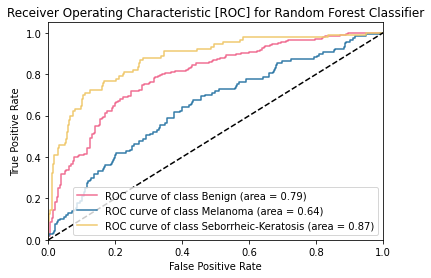


------------- ROC Curve for SVM Classifier ------------


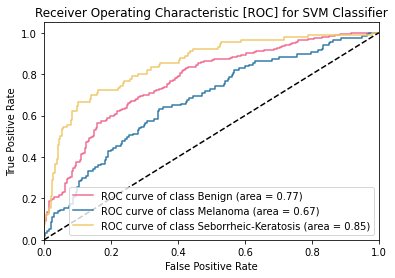


------------- ROC Curve for XGBoost Classifier ------------


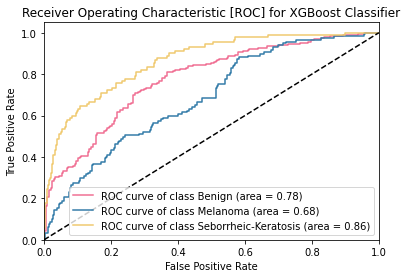

In [61]:
print('\n------------- ROC Curve for Random Forest Classifier ------------')
plot_roc(y_test, y_proba_rf, True, 'Random Forest')  
print('\n------------- ROC Curve for SVM Classifier ------------')
plot_roc(y_test, y_proba_svm, True, 'SVM')
print('\n------------- ROC Curve for XGBoost Classifier ------------')
plot_roc(y_test, y_proba_xgb, True, 'XGBoost')
print('\n')

#### ***Stacked Classifiers***

In [62]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)  

# ---  Data preprocessing :
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()), 
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)              

X_train Shape : (2150, 72)


In [63]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---------------------  Fitted models on (2150, 72)  --------------------------
with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__4_lr' + '.pkl'), 'rb') as file:
    stacking_clf4_ = pickle.load(file)
y_pred_4 = stacking_clf4_.predict(Xt_new)
y_proba_4 = stacking_clf4_.predict_proba(Xt_new)  
clf4_AUC = plot_roc(y_test, y_proba_4, False, '-')  
clf4_AUC = np.reshape([clf4_AUC[0], clf4_AUC[1], clf4_AUC[2]], (3, 1))
scores4 = get_prediction_score(y_test, y_pred_4)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__5' + '.pkl'), 'rb') as file:
    stacking_clf5_ = pickle.load(file)
y_pred_5 = stacking_clf5_.predict(Xt_new)
y_proba_5 = stacking_clf5_.predict_proba(Xt_new)  
clf5_AUC = plot_roc(y_test, y_proba_5, False, '-')  
clf5_AUC = np.reshape([clf5_AUC[0], clf5_AUC[1], clf5_AUC[2]], (3, 1))
scores5 = get_prediction_score(y_test, y_pred_5)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__6' + '.pkl'), 'rb') as file:
    stacking_clf6_ = pickle.load(file)
y_pred_6 = stacking_clf6_.predict(Xt_new)
y_proba_6 = stacking_clf6_.predict_proba(Xt_new)  
clf6_AUC = plot_roc(y_test, y_proba_6, False, '-')  
clf6_AUC = np.reshape([clf6_AUC[0], clf6_AUC[1], clf6_AUC[2]], (3, 1))
scores6 = get_prediction_score(y_test, y_pred_6)

with open(os.path.join(save_path, 'Fitted_Models', 'stacking_clf__12' + '.pkl'), 'rb') as file:
    stacking_clf12_ = pickle.load(file)
y_pred_12 = stacking_clf12_.predict(Xt_new)
y_proba_12 = stacking_clf12_.predict_proba(Xt_new)  
clf12_AUC = plot_roc(y_test, y_proba_12, False, '-')  
clf12_AUC = np.reshape([clf12_AUC[0], clf12_AUC[1], clf12_AUC[2]], (3, 1))
scores12 = get_prediction_score(y_test, y_pred_12)


In [64]:
print('Best Stacked Classifiers Scores - [Feature Vector 1 (1x72)] :')
table = [['Stacked Classifiers with [meta-lr]', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['[svmClf, rfClf]', scores4['Accuracy'], scores4['Balanced Accuracy'], scores4['Precision'], scores4['Precision'], clf4_AUC, scores4['Confusion Matrix'] ],
         ['[svmClf, xtClf, xgbClf]', scores5['Accuracy'], scores5['Balanced Accuracy'], scores5['Precision'], scores5['Recall'], clf5_AUC, scores5['Confusion Matrix'] ], 
         ['[rfClf, xtClf, xgbClf]', scores6['Accuracy'], scores6['Balanced Accuracy'], scores6['Precision'], scores6['Recall'], clf6_AUC, scores6['Confusion Matrix'] ], 
         ['[svmClf, rfClf, xtClf, knnClf]', scores12['Accuracy'], scores12['Balanced Accuracy'], scores12['Precision'], scores12['Recall'], clf12_AUC, scores12['Confusion Matrix'] ],
        ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Best Stacked Classifiers Scores - [Feature Vector 1 (1x72)] :
╒══════════════════════════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│ Stacked Classifiers with [meta-lr]   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞══════════════════════════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ [svmClf, rfClf]                      │  0.657763  │      0.630166       │  0.601439   │ 0.601439 │ [[0.79737257]  │ [[269 100  23]     │
│                                      │            │                     │             │          │  [0.74165691]  │  [ 29  72  16]     │
│                                      │            │                     │             │          │  [0.83178345]] │  [ 18  19  53]]    │
├──────────────────────────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────

* *ROC Curve and AUC values for each class*


------------- ROC Curve for [svmClf, rfClf] Classifier ------------


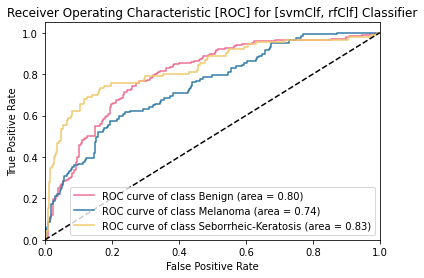


------------- ROC Curve for [svmClf, xtClf, xgbClf] Classifier ------------


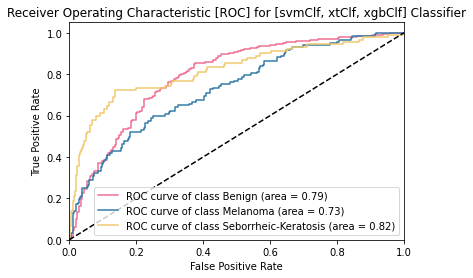


------------- ROC Curve for [rfClf, xtClf, xgbClf] Classifier ------------


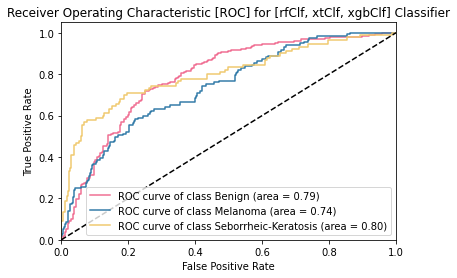


------------- ROC Curve for [svmClf, rfClf, xtClf, knnClf] Classifier ------------


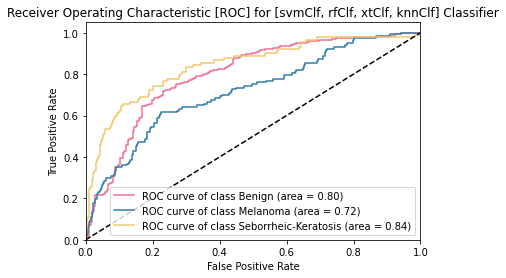

In [65]:
print('\n------------- ROC Curve for [svmClf, rfClf] Classifier ------------')
plot_roc(y_test, y_proba_4, True, '[svmClf, rfClf]')  
print('\n------------- ROC Curve for [svmClf, xtClf, xgbClf] Classifier ------------')
plot_roc(y_test, y_proba_5, True, '[svmClf, xtClf, xgbClf]')
print('\n------------- ROC Curve for [rfClf, xtClf, xgbClf] Classifier ------------')
plot_roc(y_test, y_proba_6, True, '[rfClf, xtClf, xgbClf]')
print('\n------------- ROC Curve for [svmClf, rfClf, xtClf, knnClf] Classifier ------------')
plot_roc(y_test, y_proba_12, True, '[svmClf, rfClf, xtClf, knnClf]')
print('\n')

#### ***Majority Voting***

In [66]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)  

# ---  Data preprocessing :
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()), 
  ])
model = clf.fit(X_train, y_train)
X_new = model.transform(X_train)
Xt_new = model.transform(X_test)
print('X_train Shape :', X_new.shape)             

X_train Shape : (2150, 72)


In [67]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---------------------  Fitted models on (2150, 72)  --------------------------
with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__3' + '.pkl'), 'rb') as file:
    majVoting3 = pickle.load(file)
y_pred_3 = majVoting3.predict(Xt_new)
y_proba_3 = majVoting3.predict_proba(Xt_new)  
clf3_AUC = plot_roc(y_test, y_proba_3, False, '-')  
clf3_AUC = np.reshape([clf3_AUC[0], clf3_AUC[1], clf3_AUC[2]], (3, 1))
scores3 = get_prediction_score(y_test, y_pred_3)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__4' + '.pkl'), 'rb') as file:
    majVoting4 = pickle.load(file)
y_pred_4 = majVoting4.predict(Xt_new)
y_proba_4 = majVoting4.predict_proba(Xt_new)  
clf4_AUC = plot_roc(y_test, y_proba_4, False, '-')  
clf4_AUC = np.reshape([clf4_AUC[0], clf4_AUC[1], clf4_AUC[2]], (3, 1))
scores4 = get_prediction_score(y_test, y_pred_4)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__9' + '.pkl'), 'rb') as file:
    majVoting9 = pickle.load(file)
y_pred_9 = majVoting9.predict(Xt_new)
y_proba_9 = majVoting9.predict_proba(Xt_new)  
clf9_AUC = plot_roc(y_test, y_proba_9, False, '-')  
clf9_AUC = np.reshape([clf9_AUC[0], clf9_AUC[1], clf9_AUC[2]], (3, 1))
scores9 = get_prediction_score(y_test, y_pred_9)

with open(os.path.join(save_path, 'Fitted_Models', 'majorityVoting_2150_72_soft__12' + '.pkl'), 'rb') as file:
    majVoting12 = pickle.load(file)
y_pred_12 = majVoting12.predict(Xt_new)
y_proba_12 = majVoting12.predict_proba(Xt_new)  
clf12_AUC = plot_roc(y_test, y_proba_12, False, '-')  
clf12_AUC = np.reshape([clf12_AUC[0], clf12_AUC[1], clf12_AUC[2]], (3, 1))
scores12 = get_prediction_score(y_test, y_pred_12)


In [68]:
print('Classification Results for different Majority Voting Classifiers :')
table = [['Best Majority Voting [Soft] Classifiers Scores', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'], 
         ['[svmClf, rfClf, xtClf, knnClf]', scores12['Accuracy'], scores12['Balanced Accuracy'], scores12['Precision'], scores12['Recall'], clf12_AUC, scores12['Confusion Matrix'] ],
         ['[svmClf, rfClf]', scores4['Accuracy'], scores4['Balanced Accuracy'], scores4['Precision'], scores4['Precision'], clf4_AUC, scores4['Confusion Matrix'] ],
         ['[rfClf, xgbClf, xtClf, svmClf]', scores3['Accuracy'], scores3['Balanced Accuracy'], scores3['Precision'], scores3['Recall'], clf3_AUC, scores3['Confusion Matrix'] ], 
         ['[rfClf, xtClf]', scores9['Accuracy'], scores9['Balanced Accuracy'], scores9['Precision'], scores9['Recall'], clf9_AUC, scores9['Confusion Matrix'] ], 
        ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Majority Voting Classifiers :
╒══════════════════════════════════════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════╤════════════════════╕
│ Best Majority Voting [Soft] Classifiers Scores   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ AUC            │ Confusion Matrix   │
╞══════════════════════════════════════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════╪════════════════════╡
│ [svmClf, rfClf, xtClf, knnClf]                   │  0.629382  │      0.630542       │  0.592956   │ 0.630542 │ [[0.80318939]  │ [[248 122  22]     │
│                                                  │            │                     │             │          │  [0.67608256]  │  [ 29  68  20]     │
│                                                  │            │                     │             │          │  [0.88456669]] │  [ 12  17  61]]    │
├──────────────────────────

* *ROC Curve and AUC values for each class*


------------- ROC Curve for [svmClf, rfClf, xtClf, knnClf] Classifier ------------


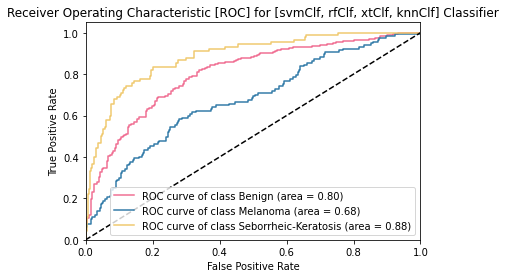


------------- ROC Curve for [svmClf, rfClf] Classifier ------------


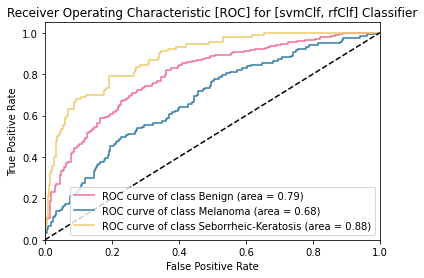


------------- ROC Curve for [rfClf, xgbClf, xtClf, svmClf] Classifier ------------


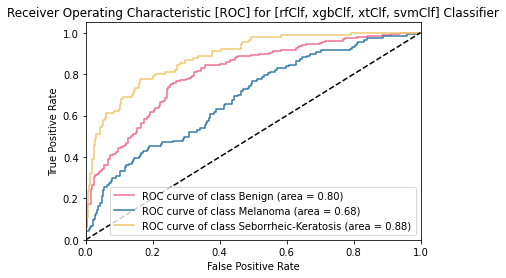


------------- ROC Curve for [rfClf, xtClf] Classifier ------------


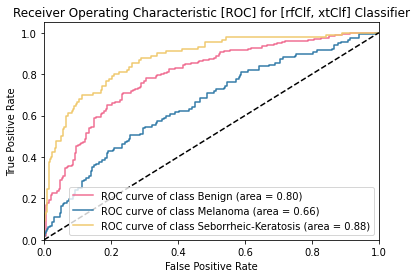

In [69]:
print('\n------------- ROC Curve for [svmClf, rfClf, xtClf, knnClf] Classifier ------------')
plot_roc(y_test, y_proba_12, True, '[svmClf, rfClf, xtClf, knnClf]')  
print('\n------------- ROC Curve for [svmClf, rfClf] Classifier ------------')
plot_roc(y_test, y_proba_4, True, '[svmClf, rfClf]')
print('\n------------- ROC Curve for [rfClf, xgbClf, xtClf, svmClf] Classifier ------------')
plot_roc(y_test, y_proba_3, True, '[rfClf, xgbClf, xtClf, svmClf]')
print('\n------------- ROC Curve for [rfClf, xtClf] Classifier ------------')
plot_roc(y_test, y_proba_9, True, '[rfClf, xtClf]')
print('\n')

# ***Hierarchical Classification***

* *In this Hierarchical classification approach, different classifiers are trained on some feature vector combination, and their parameters are optimized manually through 'for loop'*

## *Classification*

In [70]:
# ---  Reading the Saved Data :  -----------------------------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Train & Test Features :  ---------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)            

* *Converting y_train to Hierarchical Labels*

In [71]:
y_train_h = []
for i in range(len(y_train)):
  if y_train[i] == 0:
    y_train_h.append(['Benign', '0'])
  elif y_train[i] == 1:
    y_train_h.append(['Malignant', '1'])
  elif y_train[i] == 2:
    y_train_h.append(['Malignant', '2'])    

*Preprocessing the data*

In [72]:
# ---  Feature Preprocessing/Selection :  --------------------------------------
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),
    # ("Univariate Selection", PCA(0.99)),  # ----------  Feature Selection
  ])
model = clf.fit(X_train, y_train)
X_train_ = model.transform(X_train)
X_test_ = model.transform(X_test)
Y_train_ = np.array(y_train_h)
print('X_train Shape :', X_train_.shape)
print('X_train Shape :', X_test_.shape)

X_train Shape : (2150, 72)
X_train Shape : (599, 72)


### *Random Forest Classifier*

In [ ]:
#  ---------------------------------  RF :  ----------------------------------
start = time.time()

rfList1 = [100, 500, 1000, 2000]
rfList2 = [9,13,17,19,21]
rfBMA = []
for i in rfList1:
  for j in rfList2:
    # Define the Classifiers
    rf_clf = RandomForestClassifier(n_estimators=i, criterion='entropy', max_depth=j, max_features='sqrt', class_weight='balanced', random_state=0, bootstrap=False)
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = rf_clf)
    # Train local classifier 
    classifier.fit(X_train_, Y_train_)
    # Predict
    predictions = classifier.predict(X_test_)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for n_estimators:', i, 'max_depth:', j, 'criterion:entropy, is', get_prediction_score(y_test, y))
    p = get_prediction_score(y_test, y)
    rfBMA.append([p['Balanced Accuracy'], i, j]) 

end = time.time()
print('Total Time =', (end-start))
print('Results for RF', np.vstack((rfBMA)))

In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

if save_path is not None:
  # -- Random_Forest :
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_rf_2150_72_entropy' + '.pkl'), 'wb') as f:
  #         pickle.dump(classifier, f)
  # print("hiClassifier_rf_2150_72_entropy were saved..\n")

### *Support Vector Machine Classifier*

In [ ]:
#  --------------------------------  SVM :  ----------------------------------
start = time.time()

svmList = [0.1,1,10,100,1000]  # Or range(1,15)
svmBMA = []
for i in svmList:
    # Define the Classifiers
    svm_clf = SVC(kernel='rbf', C=i, probability=True, gamma='auto', tol=0.001, cache_size=200, class_weight='balanced', random_state=0, decision_function_shape='ovr')
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = svm_clf)
    # Train local classifier 
    classifier.fit(X_train_, Y_train_)
    # Predict
    predictions = classifier.predict(X_test_)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for C:', i, ', Kernel:RBF, is', get_prediction_score(y_test, y))
    p = get_prediction_score(y_test, y)
    svmBMA.append([p['Balanced Accuracy'], i]) 

end = time.time()
print('Total Time =', (end-start))    
print('Results for SVM', np.vstack((svmBMA)))

In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

if save_path is not None:
  # -- SVM :
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_svm_2150_72' + '.pkl'), 'wb') as f:
  #         pickle.dump(classifier, f)
  # print("hiClassifier_svm_2150_72 were saved..\n")

### *Extra Trees Classifier*

In [ ]:
#  ------------------------------  XTree :  ----------------------------------
start = time.time()

xtList1 = [100, 500, 1000, 2000]
xtList2 = [9,13,17,19,21]
xtBMA = []
for i in xtList1:
  for j in xtList2:
    # Define the Classifiers
    xt_clf = ExtraTreesClassifier(n_estimators=i, criterion='entropy', max_depth=j, bootstrap=False)
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = xt_clf)
    # Train local classifier 
    classifier.fit(X_train_, Y_train_)
    # Predict
    predictions = classifier.predict(X_test_)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for n_estimators:', i, 'max_depth:', j, 'criterion:entropy, is', get_prediction_score(y_test, y))
    p = get_prediction_score(y_test, y)
    xtBMA.append([p['Balanced Accuracy'], i, j]) 

end = time.time()
print('Total Time =', (end-start))    
print('Results for XT', np.vstack((xtBMA)))

In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

if save_path is not None:
  # -- Extra_Trees :
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_xtree_2150_72_entropy' + '.pkl'), 'wb') as f:
  #         pickle.dump(classifier, f)
  # print("hiClassifier_xtree_2150_72_entropy were saved..\n")

### *Gradient Boosting Classifier*

In [ ]:
#  -----------------------------  GBoost :  ----------------------------------
start = time.time()

gbList1 = [100, 500, 1000, 2000]
gbList2 = [3, 5, 7, 9, 13, 15, 17, 19, 21, 23]
gbBMA = []
for i in gbList1:
  for j in gbList2:
    # Define the Classifiers
    gb_clf = GradientBoostingClassifier(n_estimators=i, max_depth=j, learning_rate=0.1, subsample=0.7, max_features='sqrt', random_state=0)
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = gb_clf)
    # Train local classifier 
    classifier.fit(X_train_, Y_train_)
    # Predict
    predictions = classifier.predict(X_test_)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for n_estimators:', i,'max_depth:', j, ', lr:0.1, is', get_prediction_score(y_test, y))
    p = get_prediction_score(y_test, y)
    gbBMA.append([p['Balanced Accuracy'], i, j]) 

end = time.time()
print('Total Time =', (end-start))
print('Results for GB', np.vstack((gbBMA)))

In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

if save_path is not None:       
  # -- Gradient_Boosting :
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_gradBoost_2150_72_lr01' + '.pkl'), 'wb') as f:
  #         pickle.dump(classifier, f)
  # print("hiClassifier_gradBoost_2150_72_lr01 were saved..\n")

### *XGBoost Classifier*

In [ ]:
#  -----------------------------  XGBoost :  ---------------------------------
start = time.time()

xgbList1 = [100, 500, 1000, 2000]
xgbList2 = [3, 5, 7, 9, 13, 15, 17, 19, 21, 23]
xgbBMA = []
for i in xgbList1:
  for j in xgbList2:
    # Define the Classifiers
    xgb_clf = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=i, max_depth=j, learning_rate=0.1, scale_pos_weight=1)
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = xgb_clf)
    # Train local classifier
    classifier.fit(X_train_, Y_train_)
    # Predict
    predictions = classifier.predict(X_test_)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for n_estimators:', i,'max_depth:', j, ', lr:0.1, is', get_prediction_score(y_test, y))
    p = get_prediction_score(y_test, y)
    xgbBMA.append([p['Balanced Accuracy'], i, j]) 

end = time.time()
print('Total Time =', (end-start))
print('Results for XGB', np.vstack((xgbBMA)))

In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

if save_path is not None:
  # -- XGBoosting :
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_XGBoost_2150_72_lr01' + '.pkl'), 'wb') as f:
  #         pickle.dump(classifier, f)
  # print("hiClassifier_XGBoost_2150_72_lr01 were saved..\n")

### *K-Nearest Neighbors Classifier*

In [ ]:
#  ------------------------------  KNN :  ------------------------------------
start = time.time()

knnList = range(5,100,5)
knnBMA = []
for i in knnList:
    # Define the Classifiers
    knn_clf = KNeighborsClassifier(n_neighbors=i, weights='distance')  # Or weights='uniform'
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = knn_clf)
    # Train local classifier 
    classifier.fit(X_train_, Y_train_)
    # Predict
    predictions = classifier.predict(X_test_)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for n_neighbors:', i, ', weights:distance, is', get_prediction_score(y_test, y))    
    p = get_prediction_score(y_test, y)
    knnBMA.append([p['Balanced Accuracy'], i]) 

end = time.time()
print('Total Time =', (end-start))    
print('Results for KNN', np.vstack((knnBMA)))

In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

if save_path is not None:
  # -- KNN :
  # os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
  # with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_knn_2150_72_distance' + '.pkl'), 'wb') as f:
  #         pickle.dump(classifier, f)
  # print("hiClassifier_knn_2150_72_distance were saved..\n")

### ***Overall Classification Results***

* *In this subsection, the classifiers' best performances for each feature vector tested are presented*

*Graphical representation of the class hierarchy in this skin lesion classification problem*

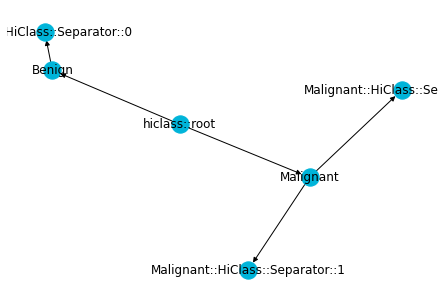

In [ ]:
# ---  Hierarchy Graph  ---
# nx.draw(classifier.hierarchy_, with_labels=True, node_color='#00b4d9')

#### *Feature Vector 1 [1x72]*

In [73]:
# ---  Reading the Saved Data :  -----------------------------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Train & Test Features :  ---------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   

y_train_h = []
for i in range(len(y_train)):
  if y_train[i] == 0:
    y_train_h.append(['Benign', '0'])
  elif y_train[i] == 1:
    y_train_h.append(['Malignant', '1'])
  elif y_train[i] == 2:
    y_train_h.append(['Malignant', '2'])    

# ---  Feature Selection/Preprocessing :  --------------------------------------
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),
  ])
model = clf.fit(X_train, y_train)
X_train_ = model.transform(X_train)
X_test_ = model.transform(X_test)
Y_train_ = np.array(y_train_h)
print('X_train Shape :', X_train_.shape)
print('X_train Shape :', X_test_.shape)             

X_train Shape : (2150, 72)
X_train Shape : (599, 72)


In [74]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---  Read the Fitted Hierarchical Models from the Save_Folder :  ---------------
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_rf_2150_72__entropy_prnt' + '.pkl'), 'rb') as file:
    rfClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_xtree_2150_72__entropy_prnt' + '.pkl'), 'rb') as file:
    xtClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_svm_2150_72___prnt' + '.pkl'), 'rb') as file:
    svmClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_gradBoost_2150_72__lr01_prnt' + '.pkl'), 'rb') as file:
    gbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_XGBoost_2150_72__lr01_prnt' + '.pkl'), 'rb') as file:
    xgbClf = pickle.load(file)    
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_knn_2150_72__uniform_prnt' + '.pkl'), 'rb') as file:
    knnClf = pickle.load(file)   

# ---  Get Prediction scores for each model :  ---------------
predictions = rfClf.predict(X_test_)
y_pred_rf = np.array(predictions[:,1]).astype('int')
rfScores = get_prediction_score(y_test, y_pred_rf)

predictions = xtClf.predict(X_test_)
y_pred_xt = np.array(predictions[:,1]).astype('int')
xtScores = get_prediction_score(y_test, y_pred_xt)

predictions = svmClf.predict(X_test_)
y_pred_svm = np.array(predictions[:,1]).astype('int')
svmScores = get_prediction_score(y_test, y_pred_svm)

predictions = gbClf.predict(X_test_)
y_pred_gb = np.array(predictions[:,1]).astype('int')
gbScores = get_prediction_score(y_test, y_pred_gb)

predictions = xgbClf.predict(X_test_)
y_pred_xgb = np.array(predictions[:,1]).astype('int')
xgbScores = get_prediction_score(y_test, y_pred_xgb)

predictions = knnClf.predict(X_test_)
y_pred_knn = np.array(predictions[:,1]).astype('int')
knnScores = get_prediction_score(y_test, y_pred_knn)

In [75]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results for different Classifiers [Feature vector 1 (1x72)]:')
table = [[' ', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'Confusion Matrix'], 
         ['Random Forest', rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'], rfScores['Recall'], rfScores['Confusion Matrix'] ], 
         ['Extra Trees', xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtScores['Confusion Matrix'] ], 
         ['SVM', svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbScores['Confusion Matrix'] ],
         ['XGBoosting', xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbScores['Confusion Matrix'] ],
         ['KNN', knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnScores['Confusion Matrix'] ],
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Classifiers [Feature vector 1 (1x72)]:
╒═══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════════╕
│                   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ Confusion Matrix   │
╞═══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════════╡
│ Random Forest     │  0.589316  │      0.627833       │  0.567467   │ 0.627833 │ [[216 134  42]     │
│                   │            │                     │             │          │  [ 23  74  20]     │
│                   │            │                     │             │          │  [  9  18  63]]    │
├───────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────────┤
│ Extra Trees       │  0.602671  │      0.600961       │  0.576522   │ 0.600961 │ [[237 133  22]     │
│                   │            │                     │             │          │  [ 27  70  20]    

##### *Feature Vector 1 [1x72] with PCA*

In [76]:
# ---  Reading the Saved Data :  -----------------------------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Train & Test Features :  ---------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_72' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_72' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_72' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_72' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   

y_train_h = []
for i in range(len(y_train)):
  if y_train[i] == 0:
    y_train_h.append(['Benign', '0'])
  elif y_train[i] == 1:
    y_train_h.append(['Malignant', '1'])
  elif y_train[i] == 2:
    y_train_h.append(['Malignant', '2'])    

# ---  Feature Selection/Preprocessing :  --------------------------------------
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),
    ("Univariate Selection", PCA(0.99)),  # ----------  Feature Selection
  ])
model = clf.fit(X_train, y_train)
X_train_ = model.transform(X_train)
X_test_ = model.transform(X_test)
Y_train_ = np.array(y_train_h)
print('X_train Shape :', X_train_.shape)
print('X_train Shape :', X_test_.shape)             

X_train Shape : (2150, 33)
X_train Shape : (599, 33)


In [77]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---  Read the Fitted Hierarchical Models from the Save_Folder :  ---------------
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_rf_2150_72__entropy_prnt_pca' + '.pkl'), 'rb') as file:
    rfClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_xtree_2150_72__entropy_prnt_pca' + '.pkl'), 'rb') as file:
    xtClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_svm_2150_72___prnt_pca' + '.pkl'), 'rb') as file:
    svmClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_gradBoost_2150_72__lr01_prnt_pca' + '.pkl'), 'rb') as file:
    gbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_XGBoost_2150_72__lr001_prnt_pca' + '.pkl'), 'rb') as file:
    xgbClf = pickle.load(file)    
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_knn_2150_72__uniform_prnt_pca' + '.pkl'), 'rb') as file:
    knnClf = pickle.load(file)   

# ---  Get Prediction scores for each model :  ---------------
predictions = rfClf.predict(X_test_)
y_pred_rf = np.array(predictions[:,1]).astype('int')
rfScores = get_prediction_score(y_test, y_pred_rf)

predictions = xtClf.predict(X_test_)
y_pred_xt = np.array(predictions[:,1]).astype('int')
xtScores = get_prediction_score(y_test, y_pred_xt)

predictions = svmClf.predict(X_test_)
y_pred_svm = np.array(predictions[:,1]).astype('int')
svmScores = get_prediction_score(y_test, y_pred_svm)

predictions = gbClf.predict(X_test_)
y_pred_gb = np.array(predictions[:,1]).astype('int')
gbScores = get_prediction_score(y_test, y_pred_gb)

predictions = xgbClf.predict(X_test_)
y_pred_xgb = np.array(predictions[:,1]).astype('int')
xgbScores = get_prediction_score(y_test, y_pred_xgb)

predictions = knnClf.predict(X_test_)
y_pred_knn = np.array(predictions[:,1]).astype('int')
knnScores = get_prediction_score(y_test, y_pred_knn)

* *The table below shows the scores obtained with the feature vector 1 when PCA was applied. The performances did not improve*

In [78]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results for different Classifiers [Feature vector 1 (1x72) + PCA]:')
table = [[' ', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'Confusion Matrix'], 
         ['Random Forest', rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'], rfScores['Recall'], rfScores['Confusion Matrix'] ], 
         ['Extra Trees', xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtScores['Confusion Matrix'] ], 
         ['SVM', svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbScores['Confusion Matrix'] ],
         ['XGBoosting', xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbScores['Confusion Matrix'] ],
         ['KNN', knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnScores['Confusion Matrix'] ],
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Classifiers [Feature vector 1 (1x72) + PCA]:
╒═══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════════╕
│                   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ Confusion Matrix   │
╞═══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════════╡
│ Random Forest     │  0.612688  │       0.5858        │  0.562533   │  0.5858  │ [[251 113  28]     │
│                   │            │                     │             │          │  [ 34  67  16]     │
│                   │            │                     │             │          │  [ 16  25  49]]    │
├───────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────────┤
│ Extra Trees       │  0.554257  │      0.571462       │  0.562498   │ 0.571462 │ [[207 161  24]     │
│                   │            │                     │             │          │  [ 24  79  1

#### *Feature Vector 2 [1x92]*

In [79]:
# ---  Reading the Saved Data :  -----------------------------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Train & Test Features :  ---------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_92' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_92' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_92' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_92' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   

y_train_h = []
for i in range(len(y_train)):
  if y_train[i] == 0:
    y_train_h.append(['Benign', '0'])
  elif y_train[i] == 1:
    y_train_h.append(['Malignant', '1'])
  elif y_train[i] == 2:
    y_train_h.append(['Malignant', '2'])    

# ---  Feature Selection/Preprocessing :  --------------------------------------
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),
  ])
model = clf.fit(X_train, y_train)
X_train_ = model.transform(X_train)
X_test_ = model.transform(X_test)
Y_train_ = np.array(y_train_h)
print('X_train Shape :', X_train_.shape)
print('X_train Shape :', X_test_.shape)             

X_train Shape : (2150, 92)
X_train Shape : (599, 92)


In [80]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---  Read the Fitted Hierarchical Models from the Save_Folder :  ---------------
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_rf_2150_92__entropy_prnt' + '.pkl'), 'rb') as file:
    rfClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_xtree_2150_92__entropy_prnt' + '.pkl'), 'rb') as file:
    xtClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_svm_2150_92___prnt' + '.pkl'), 'rb') as file:
    svmClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_gradBoost_2150_92__lr01_prnt' + '.pkl'), 'rb') as file:
    gbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_XGBoost_2150_92__lr001_prnt' + '.pkl'), 'rb') as file:
    xgbClf = pickle.load(file)    
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_knn_2150_92__distance_prnt' + '.pkl'), 'rb') as file:
    knnClf = pickle.load(file)   

# ---  Get Prediction scores for each model :  ---------------
predictions = rfClf.predict(X_test_)
y_pred_rf = np.array(predictions[:,1]).astype('int')
rfScores = get_prediction_score(y_test, y_pred_rf)

predictions = xtClf.predict(X_test_)
y_pred_xt = np.array(predictions[:,1]).astype('int')
xtScores = get_prediction_score(y_test, y_pred_xt)

predictions = svmClf.predict(X_test_)
y_pred_svm = np.array(predictions[:,1]).astype('int')
svmScores = get_prediction_score(y_test, y_pred_svm)

predictions = gbClf.predict(X_test_)
y_pred_gb = np.array(predictions[:,1]).astype('int')
gbScores = get_prediction_score(y_test, y_pred_gb)

predictions = xgbClf.predict(X_test_)
y_pred_xgb = np.array(predictions[:,1]).astype('int')
xgbScores = get_prediction_score(y_test, y_pred_xgb)

predictions = knnClf.predict(X_test_)
y_pred_knn = np.array(predictions[:,1]).astype('int')
knnScores = get_prediction_score(y_test, y_pred_knn)

In [81]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results for different Classifiers [Feature vector 2 (1x92)]:')
table = [[' ', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'Confusion Matrix'], 
         ['Random Forest', rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'], rfScores['Recall'], rfScores['Confusion Matrix'] ], 
         ['Extra Trees', xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtScores['Confusion Matrix'] ], 
         ['SVM', svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbScores['Confusion Matrix'] ],
         ['XGBoosting', xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbScores['Confusion Matrix'] ],
         ['KNN', knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnScores['Confusion Matrix'] ],
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Classifiers [Feature vector 2 (1x92)]:
╒═══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════════╕
│                   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ Confusion Matrix   │
╞═══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════════╡
│ Random Forest     │  0.594324  │       0.62924       │   0.57159   │ 0.62924  │ [[220 135  37]     │
│                   │            │                     │             │          │  [ 23  72  22]     │
│                   │            │                     │             │          │  [  9  17  64]]    │
├───────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────────┤
│ Extra Trees       │  0.597663  │      0.595833       │  0.558631   │ 0.595833 │ [[237 125  30]     │
│                   │            │                     │             │          │  [ 34  63  20]    

#### *Feature Vector 5 [1x59]*

In [88]:
# ---  Reading the Saved Data :  -----------------------------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Train & Test Features :  ---------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_59_textureFt' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_59_textureFt' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_59_textureFt' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_59_textureFt' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   

y_train_h = []
for i in range(len(y_train)):
  if y_train[i] == 0:
    y_train_h.append(['Benign', '0'])
  elif y_train[i] == 1:
    y_train_h.append(['Malignant', '1'])
  elif y_train[i] == 2:
    y_train_h.append(['Malignant', '2'])    

# ---  Feature Selection/Preprocessing :  --------------------------------------
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),
  ])
model = clf.fit(X_train, y_train)
X_train_ = model.transform(X_train)
X_test_ = model.transform(X_test)
Y_train_ = np.array(y_train_h)
print('X_train Shape :', X_train_.shape)
print('X_train Shape :', X_test_.shape)             

X_train Shape : (2150, 59)
X_train Shape : (599, 59)


In [89]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---  Read the Fitted Hierarchical Models from the Save_Folder :  ---------------
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_rf_2150_59__entropy_prnt' + '.pkl'), 'rb') as file:
    rfClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_xtree_2150_59__entropy_prnt' + '.pkl'), 'rb') as file:
    xtClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_svm_2150_59___prnt' + '.pkl'), 'rb') as file:
    svmClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_gradBoost_2150_59__lr001_prnt' + '.pkl'), 'rb') as file:
    gbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_XGBoost_2150_59__lr01_prnt' + '.pkl'), 'rb') as file:
    xgbClf = pickle.load(file)    
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_knn_2150_59__uniform_prnt' + '.pkl'), 'rb') as file:
    knnClf = pickle.load(file)   

# ---  Get Prediction scores for each model :  ---------------
predictions = rfClf.predict(X_test_)
y_pred_rf = np.array(predictions[:,1]).astype('int')
rfScores = get_prediction_score(y_test, y_pred_rf)

predictions = xtClf.predict(X_test_)
y_pred_xt = np.array(predictions[:,1]).astype('int')
xtScores = get_prediction_score(y_test, y_pred_xt)

predictions = svmClf.predict(X_test_)
y_pred_svm = np.array(predictions[:,1]).astype('int')
svmScores = get_prediction_score(y_test, y_pred_svm)

predictions = gbClf.predict(X_test_)
y_pred_gb = np.array(predictions[:,1]).astype('int')
gbScores = get_prediction_score(y_test, y_pred_gb)

predictions = xgbClf.predict(X_test_)
y_pred_xgb = np.array(predictions[:,1]).astype('int')
xgbScores = get_prediction_score(y_test, y_pred_xgb)

predictions = knnClf.predict(X_test_)
y_pred_knn = np.array(predictions[:,1]).astype('int')
knnScores = get_prediction_score(y_test, y_pred_knn)

In [84]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results for different Classifiers [Feature vector 5 (1x59)]:')
table = [[' ', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'Confusion Matrix'], 
         ['Random Forest', rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'], rfScores['Recall'], rfScores['Confusion Matrix'] ], 
         ['Extra Trees', xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtScores['Confusion Matrix'] ], 
         ['SVM', svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbScores['Confusion Matrix'] ],
         ['XGBoosting', xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbScores['Confusion Matrix'] ],
         ['KNN', knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnScores['Confusion Matrix'] ],
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Classifiers [Feature vector 5 (1x59)]:
╒═══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════════╕
│                   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ Confusion Matrix   │
╞═══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════════╡
│ Random Forest     │  0.604341  │       0.61095       │  0.588165   │ 0.61095  │ [[233 133  26]     │
│                   │            │                     │             │          │  [ 31  76  10]     │
│                   │            │                     │             │          │  [ 12  25  53]]    │
├───────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────────┤
│ Extra Trees       │  0.57429   │      0.578234       │  0.551007   │ 0.578234 │ [[222 137  33]     │
│                   │            │                     │             │          │  [ 30  73  14]    

#### *Feature Vector 7 [1x9]*

In [85]:
# ---  Reading the Saved Data :  -----------------------------------------------
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# -- Read Train & Test Features :  ---------------------------------------------
with open(os.path.join(save_path, 'Features', 'X_train_2150_9_globalFt' + '.pkl'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_train_2150_9_globalFt' + '.pkl'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'X_test_2150_9_globalFt' + '.pkl'), 'rb') as file:
    X_test = pickle.load(file)
with open(os.path.join(save_path, 'Features', 'y_test_2150_9_globalFt' + '.pkl'), 'rb') as file:
    y_test = pickle.load(file)   

y_train_h = []
for i in range(len(y_train)):
  if y_train[i] == 0:
    y_train_h.append(['Benign', '0'])
  elif y_train[i] == 1:
    y_train_h.append(['Malignant', '1'])
  elif y_train[i] == 2:
    y_train_h.append(['Malignant', '2'])    

# ---  Feature Selection/Preprocessing :  --------------------------------------
clf = Pipeline([
    ('Standardization', preprocessing.StandardScaler()),
  ])
model = clf.fit(X_train, y_train)
X_train_ = model.transform(X_train)
X_test_ = model.transform(X_test)
Y_train_ = np.array(y_train_h)
print('X_train Shape :', X_train_.shape)
print('X_train Shape :', X_test_.shape)             

X_train Shape : (2150, 9)
X_train Shape : (599, 9)


In [86]:
save_path = '/content/drive/MyDrive/Skin Lesions Dataset/Dataset_2/Save_Folder_2'

# ---  Read the Fitted Hierarchical Models from the Save_Folder :  ---------------
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_rf_2150_9__entropy_prnt' + '.pkl'), 'rb') as file:
    rfClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_xtree_2150_9__gini_prnt' + '.pkl'), 'rb') as file:
    xtClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_svm_2150_9___prnt' + '.pkl'), 'rb') as file:
    svmClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_gradBoost_2150_9__lr01_prnt' + '.pkl'), 'rb') as file:
    gbClf = pickle.load(file)
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_XGBoost_2150_9__lr001_prnt' + '.pkl'), 'rb') as file:
    xgbClf = pickle.load(file)    
with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_knn_2150_9__uniform_prnt' + '.pkl'), 'rb') as file:
    knnClf = pickle.load(file)   

# ---  Get Prediction scores for each model :  ---------------
predictions = rfClf.predict(X_test_)
y_pred_rf = np.array(predictions[:,1]).astype('int')
rfScores = get_prediction_score(y_test, y_pred_rf)

predictions = xtClf.predict(X_test_)
y_pred_xt = np.array(predictions[:,1]).astype('int')
xtScores = get_prediction_score(y_test, y_pred_xt)

predictions = svmClf.predict(X_test_)
y_pred_svm = np.array(predictions[:,1]).astype('int')
svmScores = get_prediction_score(y_test, y_pred_svm)

predictions = gbClf.predict(X_test_)
y_pred_gb = np.array(predictions[:,1]).astype('int')
gbScores = get_prediction_score(y_test, y_pred_gb)

predictions = xgbClf.predict(X_test_)
y_pred_xgb = np.array(predictions[:,1]).astype('int')
xgbScores = get_prediction_score(y_test, y_pred_xgb)

predictions = knnClf.predict(X_test_)
y_pred_knn = np.array(predictions[:,1]).astype('int')
knnScores = get_prediction_score(y_test, y_pred_knn)

In [87]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results for different Classifiers [Feature vector 7 (1x9)]:')
table = [[' ', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'Confusion Matrix'], 
         ['Random Forest', rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'], rfScores['Recall'], rfScores['Confusion Matrix'] ], 
         ['Extra Trees', xtScores['Accuracy'], xtScores['Balanced Accuracy'], xtScores['Precision'], xtScores['Recall'], xtScores['Confusion Matrix'] ], 
         ['SVM', svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbScores['Confusion Matrix'] ],
         ['XGBoosting', xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbScores['Confusion Matrix'] ],
         ['KNN', knnScores['Accuracy'], knnScores['Balanced Accuracy'], knnScores['Precision'], knnScores['Recall'], knnScores['Confusion Matrix'] ],
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Classifiers [Feature vector 7 (1x9)]:
╒═══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════════╕
│                   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ Confusion Matrix   │
╞═══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════════╡
│ Random Forest     │  0.590985  │      0.477416       │  0.474131   │ 0.477416 │ [[279  81  32]     │
│                   │            │                     │             │          │  [ 50  44  23]     │
│                   │            │                     │             │          │  [ 34  25  31]]    │
├───────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────────┤
│ Extra Trees       │  0.524207  │      0.521035       │  0.496842   │ 0.521035 │ [[207 144  41]     │
│                   │            │                     │             │          │  [ 26  60  31]     

## *Classification Result [Best Scores]*

* *In this subsection, the best performing models are presented*

In [ ]:
# ---  Show Prediction Scores for each of the Best Classifier :  -----------------------------

print('Classification Results for different Classifiers [Feature vector 1 (1x72)]:')
table = [[' ', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'Confusion Matrix'], 
         ['SVM', svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmScores['Confusion Matrix'] ], 
         ['Random Forest', rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'], rfScores['Recall'], rfScores['Confusion Matrix'] ], 
         ['XGBoosting', xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbScores['Confusion Matrix'] ],         
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Classifiers [Feature vector 1 (1x72)]:
╒═══════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════════╕
│               │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ Confusion Matrix   │
╞═══════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════════╡
│ SVM           │  0.624374  │      0.634842       │  0.570158   │ 0.634842 │ [[242 108  42]     │
│               │            │                     │             │          │  [ 21  70  26]     │
│               │            │                     │             │          │  [ 18  10  62]]    │
├───────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────────┤
│ Random Forest │  0.589316  │      0.627833       │  0.567467   │ 0.627833 │ [[216 134  42]     │
│               │            │                     │             │          │  [ 23  74  20]     │
│               │            │   

In [ ]:
# ---  Show Prediction Scores for each of the Best Classifier :  -----------------------------

print('Classification Results for different Classifiers [Feature vector 2 (1x92)]:')
table = [[' ', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'Confusion Matrix'], 
         ['XGBoosting', xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbScores['Confusion Matrix'] ],
         ['Random Forest', rfScores['Accuracy'], rfScores['Balanced Accuracy'], rfScores['Precision'], rfScores['Recall'], rfScores['Confusion Matrix'] ], 
         ['SVM', svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmScores['Confusion Matrix'] ], 
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Classifiers [Feature vector 2 (1x92)]:
╒═══════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════════╕
│               │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ Confusion Matrix   │
╞═══════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════════╡
│ XGBoosting    │  0.621035  │      0.629999       │  0.569947   │ 0.629999 │ [[242 108  42]     │
│               │            │                     │             │          │  [ 27  67  23]     │
│               │            │                     │             │          │  [  9  18  63]]    │
├───────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────────┤
│ Random Forest │  0.594324  │       0.62924       │   0.57159   │ 0.62924  │ [[220 135  37]     │
│               │            │                     │             │          │  [ 23  72  22]     │
│               │            │   

In [91]:
# ---  Show Prediction Scores for each of the Best Classifier :  -----------------------------

print('Classification Results for different Classifiers [Feature vector 5 (1x59)]:')
table = [[' ', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'Confusion Matrix'], 
         ['XGBoosting', xgbScores['Accuracy'], xgbScores['Balanced Accuracy'], xgbScores['Precision'], xgbScores['Recall'], xgbScores['Confusion Matrix'] ],
         ['SVM', svmScores['Accuracy'], svmScores['Balanced Accuracy'], svmScores['Precision'], svmScores['Recall'], svmScores['Confusion Matrix'] ], 
         ['Gradient Boosting', gbScores['Accuracy'], gbScores['Balanced Accuracy'], gbScores['Precision'], gbScores['Recall'], gbScores['Confusion Matrix'] ],
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results for different Classifiers [Feature vector 5 (1x59)]:
╒═══════════════════╤════════════╤═════════════════════╤═════════════╤══════════╤════════════════════╕
│                   │  Accuracy  │  Balanced Accuracy  │  Precision  │  Recall  │ Confusion Matrix   │
╞═══════════════════╪════════════╪═════════════════════╪═════════════╪══════════╪════════════════════╡
│ XGBoosting        │  0.624374  │      0.634277       │  0.579313   │ 0.634277 │ [[241 113  38]     │
│                   │            │                     │             │          │  [ 26  74  17]     │
│                   │            │                     │             │          │  [ 14  17  59]]    │
├───────────────────┼────────────┼─────────────────────┼─────────────┼──────────┼────────────────────┤
│ SVM               │  0.612688  │      0.622907       │  0.569714   │ 0.622907 │ [[235 113  44]     │
│                   │            │                     │             │          │  [ 23  77  17]    

# *Resources*

***Feature Extraction***

*   BoundingBox : https://www.delftstack.com/howto/python/opencv-bounding-box/

*   Random Oversampling : https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

*   https://docs.opencv.org/4.x/d1/d32/tutorial_py_contour_properties.html

*   https://github.com/biagiom/skin-lesions-classifier/blob/master/skin_lesions_classifier.ipynb

*   Color moments : https://developpaper.com/image-color-feature-extraction-color-histogram-color-moment-python/

*   https://github.com/liambll/skin-lesion-classification/blob/master/models/feature_extraction.py

*   https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

***Flat Architecture***

*   https://www.kaggle.com/code/obiaf88/stacking-classifiers-with-gridsearch/notebook

*   https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/

*   https://github.com/liambll/skin-lesion-classification

*   http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

***Hierarchical Architecture***

*   HiClass : https://pypi.org/project/hiclass/

*   https://colab.research.google.com/drive/1Idzht9dNoB85pjc9gOL24t9ksrXZEA-9?usp=sharing#scrollTo=G2Ve7UKheLxX